In [1]:
# import required packages
import imnn.lfi
from imnn.utils import value_and_jacrev, value_and_jacfwd
import jax
import jax.numpy as jnp
import jraph
import jax_cosmo as jc

import numpy as onp

import gc
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('white')

# Assembling Dark Matter Halo Graphs

To get a better sense of what graphs look like, let's pick apart a single cosmic graph, assembled from a dark matter halo catalogue. This catalogue was constructed from the [*Quijote* simulations](https://quijote-simulations.readthedocs.io/en/latest/index.html). These simulations evolve the Dark Matter field on a $(1\rm \ Gpc)^3$ box under gravity from initial conditions to large-scale structure formation. Collections of dark matter particles are then catalogued into hierarchical "halos" of different sizes using the Friend of Friends (FoF) algorithm.

We're going to use the [`jraph` library](https://github.com/deepmind/jraph) to construct our graphs.

In [2]:
#@title graph utils module <font color='lightgreen'>[run me]</font>
import jax.random as jrnd
from functools import partial
import scipy.spatial as SS

import numpy as onp

from functools import partial
import jax
import jax.random as jrnd
import jax.numpy as jnp
import jraph
from scipy.sparse import csgraph
import numpy as np
import os, sys
from struct import unpack

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

#####################


def get_distances(X):
    nx = X.shape[0]
    return (X[:, None, :] - X[None, :, :])[jnp.tril_indices(nx, k=-1)]


def get_receivers_senders(nx, dists, connect_radius=0.15):
    '''connect nodes within `connect_radius` units'''
    
    senders,receivers = jnp.tril_indices(nx, k=-1)
    dists = dists[jnp.tril_indices(nx, k=-1)]
    mask = dists < connect_radius
    # pad dummy s,r with n_node
    senders = jnp.where(mask > 0, senders, nx)
    receivers = jnp.where(mask > 0, receivers, nx)
    dists = jnp.where(mask > 0, dists, 0.)
    return senders, receivers, dists

def l2norm_einsum(X, eps=1e-9):
    """calculaute eucl distance with einsum"""
    a_min_b = X[:, None, :] - X[None, :, :]
    norm_sq = jnp.einsum("ijk,ijk->ij", a_min_b, a_min_b)
    return jnp.where(norm_sq < eps, 0, jnp.sqrt(norm_sq))

def get_r2(X):
    """calculate euclidean distance from positional information"""
    nx = X.shape[0]
    #alldists = l2norm(X[:, None, :] - X[None, :, :])
    alldists = l2norm_einsum(X)
    return alldists #[jnp.tril_indices(nx, k=-1)]


##### GET EDGES #####
def edge_builder(pos, r_connect, n_node=None, invert_edges=True,
                     boxsize=1.0001, leafsize=16):
    
    if n_node is not None:
        pos = pos[:n_node]
    
    else:
      n_node = pos.shape[0]

    r_connect = r_connect #simulator_args["connect_radius"] / simulator_args["L"]

    # mask out halos with distances < connect_radius
    dists = get_r2(pos)
    
    _receivers, _senders, dists = get_receivers_senders(n_node, 
                                                        dists, 
                                                        connect_radius=r_connect)

    diff = pos[_senders] - pos[_receivers]

    num_pairs = dists.shape[0]
    row = _senders
    col = _receivers
    
    # Distance
    dist = dists
    
    # Centroid of galaxy catalogue
    centroid = jnp.mean(pos,axis=0)
    
    # Unit vectors of node, neighbor and difference vector
    unitrow = (pos[row]-centroid)/jnp.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
    unitcol = (pos[col]-centroid)/jnp.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
    
    unitdiff = jnp.where((dist.reshape(-1,1) > 0.), diff/dist.reshape(-1,1), 1.)
    
    # Dot products between unit vectors
    cos1 = jnp.einsum('ij,ij->i', unitrow, unitcol)
    cos2 = jnp.einsum('ij,ij->i', unitrow, unitdiff)

    # mask out nans
    cos1 = jnp.where(dist == 0., 0., cos1)
    cos2 = jnp.where(dist == 0., 0., cos2)
    
    if invert_edges:
        # flip the distance
        dist = jnp.where((dist > 0.), 1. / (dist*r_connect*100.), dist)
        # sort edges from biggest to smallest
        idx = jnp.argsort(dist)[::-1]
        dist = jnp.sort(dist)[::-1]
    
    else:
        # Normalize distance by linking radius
        dist /= r_connect
        # pad with large dummy edge
        mask = (dist > 0.)
        fillval = 100.
        dist = jnp.where(mask < 1, fillval, dist)
        
        # sort edges from SMALLEST to BIGGEST
        idx = jnp.argsort(dist) #[::-1]
        dist = jnp.sort(dist) #[::-1]
        
        # replace all dummy distances with zeros again
        dist = jnp.where(dist == fillval, 0., dist)



    cos1 = cos1[idx]
    cos2 = cos2[idx]

    _senders = _senders[idx]
    _receivers = _receivers[idx]

    edge_attr = jnp.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)
    
    return edge_attr, jnp.array(_senders), jnp.array(_receivers)




##### GET GRAPH PADDING #####

def padded_graph_builder(catalog, θ, simulator_args, r_connect=None, n_node=None):
      
    pad_nodes_to = simulator_args['pad_nodes_to']
    pad_edges_to = simulator_args['pad_edges_to']
    include_pos = simulator_args["include_pos"]
    node_features = simulator_args["node_features"]

    # get empty arrays
    if include_pos:
        nodes = jnp.zeros((pad_nodes_to, node_features))
        edges = jnp.zeros((pad_edges_to, 1)) # dist

    else:
        nodes = jnp.zeros((pad_nodes_to, 4)) # density, neighborhood info
        edges = jnp.zeros((pad_edges_to, 3)) # dist, angle, angle
    
    senders = (jnp.ones((pad_edges_to), dtype=int)*pad_nodes_to).astype(int)
    receivers = (jnp.ones((pad_edges_to), dtype=int)*pad_nodes_to).astype(int)
    
    
    # dealing with the padded catalog
    # set the dummy nodes' positions to way outside the box
    catalog = jnp.where((catalog[:, 0] == 0.)[:, jnp.newaxis],
                        jnp.array([0., 0., 0., 0., 100., 100., 100.]),
                        catalog)
    
    # unpack node attributes from catalog
    pos = catalog[:, 4:]
    
    # reset dummy positions to zero after passing to pos
    catalog = jnp.where((catalog[:, 0] > 0.)[:, jnp.newaxis], catalog, 0.)
    
    if include_pos:
        node_attr = catalog[:, :]

    else:
        node_attr = catalog[:, :4]
      
    n_node = jnp.sum(node_attr[:, 0] > 0.)
    
    # GET EDGE INFORMATION
    edge_attr, _s, _r = edge_builder(jnp.array(pos), r_connect=r_connect,
                                     invert_edges=simulator_args["invert_edges"],
                                     boxsize=1.0001)
    
    if include_pos:
        edge_attr = edge_attr[:, :1]
    
    n_edge = jnp.sum(edge_attr[:, 0] > 0.)
    
    # fill in jax arrays
    
    # edge information
    edges = edges.at[:pad_edges_to, :].set(edge_attr[:pad_edges_to, :])
    senders = senders.at[:pad_edges_to].set(_s[:pad_edges_to])
    receivers = receivers.at[:pad_edges_to].set(_r[:pad_edges_to])

    # add in node information
    nodes = nodes.at[:pad_nodes_to, :].set(node_attr[:pad_nodes_to])

    if simulator_args["squeeze"]:

        graph = jraph.GraphsTuple(nodes=jnp.squeeze(nodes), edges=jnp.squeeze(edges),
                              senders=jnp.squeeze(senders), receivers=jnp.squeeze(receivers),
                              n_node=jnp.array([n_node]), n_edge=jnp.array([n_edge]), globals=jnp.array([θ])
                              )
        return graph

    else:
        graph = jraph.GraphsTuple(nodes=nodes, edges=edges,
                                senders=senders, receivers=receivers,
                                n_node=jnp.array([n_node]), n_edge=jnp.array([n_edge]), globals=jnp.array([θ])
                                )
        return graph


####################### VISUALIZE GRAPH #######################

def plot_graph(graph,
                ax=None,
                nodesize=45,
                nodealpha=0.5,
                edgewidth=1.5,
                edgealpha=0.5,
                labelaxes=False,
                removeticks=False,
                removebox=False):
    """visualize jraph graph using Networkx"""
    
    send_receive = [(int(graph.senders[l]), int(graph.receivers[l])) for l in range(len(graph.receivers))]
    
    G = nx.Graph()
    G.add_nodes_from(list(np.arange(graph.nodes[:, :1].shape[0])))
    G.add_edges_from(send_receive)


    # 3d spring layout
    pos = graph.nodes[:, 1:4] #X 
    
    masses = graph.nodes[:, 0]
    
    
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
    
    if ax is None:
            # Create the 3D figure
        fig = plt.figure(figsize=(7,4))
        ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    sc = ax.scatter(*node_xyz.T, s=nodesize, ec='w', 
                    c=masses, cmap='gist_gray', alpha=nodealpha)



    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray", lw=edgewidth, alpha=edgealpha)


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        if removeticks:
            for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
                dim.set_ticks([])
                
        if removebox:
            for key, spine in ax.spines.items():
                spine.set_visible(False)
            ax.axis('off')
        if labelaxes:
            # Set axes labels
            ax.set_xlabel(r"$x\ \rm [Mpc/h]$", fontsize=15)
            ax.set_ylabel(r"$y$", fontsize=15)
            ax.set_zlabel(r"$z$", fontsize=15)


    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')


    ax.view_init(azim=15, elev=20)
    _format_axes(ax)  
    #plt.show()
    
    return ax

def load_single_unpadded_graph(fname, idx, masscut, r_connect):
  _graph = load_obj(fname)
  catalog = _graph.nodes[idx] # take first simulation
  catalog = catalog[catalog[:, 0] > masscut] # remove padding, with masscut

  pos = catalog[:, 4:]

  catalog = jnp.concatenate([catalog[:, :1], catalog[:, 4:]], axis=-1)

  edge_attr, _s, _r = edge_builder(jnp.array(pos), r_connect=r_connect,
                                  invert_edges=simulator_args["invert_edges"],
                                  boxsize=1.0001)
  
  edgemask = edge_attr[:, 0] > 0
  edge_attr = edge_attr[edgemask, 0]
  _s = _s[edgemask]
  _r = _r[edgemask]

  return jraph.GraphsTuple(nodes=catalog,
                           edges=edge_attr,
                           senders=_s,
                           receivers=_r,
                           n_node=_graph.n_node[idx],
                           n_edge=_graph.n_edge[idx],
                           globals=_graph.globals[idx])

# default simulator args
N=512
shape=(N,N,N)
simulator_args = dict(
        connect_radius=0.2,
        mass_cut=1.5,             # 10^15 Msun
        do_noise=False,
        nbar=0.0015,    # GIVES US A LOT MORE NODES
        pad_nodes_to=200,
        pad_edges_to= 500, # 1150, 500, 100 for 0.3, 0.2, 0.1
        include_pos=False,
        invert_edges=False,
        squeeze=False,
        boxsize=None, # or 1.0001
        return_cat=False,
        node_features=7)

## visualize a dark matter graph

Here we're going to construct a single, unpadded graph from a halo catalogue. We'll plot both a catalogue with halos of mass $M_i>M_{\rm cut}=1.1\times10^{15} M_{\odot}$, as well as those with masses $M_i > M_{\rm cut}=1.5\times10^{15} M_{\odot} $. We'll connect every halo to every neighboring halo within a radius of $r_{\rm connect}=200\ \textrm{Mpc} = 0.2\ \textrm{Gpc} $.

These two physical parameters change the *cardinality* of the graph, or the length of the set of edges and nodes. The helper function `load_single_unpadded_graph()` takes in a set of nodes (here loaded as a `.pkl` and computes edges between halo positions. The output graph has features
$$ \begin{align}
\textbf{e}_{ij} &= d_{ij}\ \ \ \ \ \ \ \ \ \   \texttt{# the distance between halos i and j}  \\
  \textbf{v}_i &= [M_i, \textbf{p}_i],\ \ \ \ \ \  \texttt{# mass, (x,y,z) position} 
  \end{align}
$$
In the `jraph` representation, we flatten the $i,j$ edge index into a $k$ index, with senders and receivers indexes denoted $s_k$ and $r_k$, respectively.


In [3]:
outdir = '/data80/makinen/quijote/graphs/png/z_1/'

# Forward-simulating catalogue cuts

Furthermore, since we're learning from simulations, we're free to add all sorts of noise and effects to the data during network training. In this tutorial we'll add *new white noise* to the halo masses every training epoch to mimic more realistic data collection from galaxy clusters.

Our noise model will look like:
$$ \hat{m}_i = m_i + \mathcal{N}(0,\sigma^2_{\rm noise}) $$
with $\sigma_{\rm noise} = A_{\rm noise}M_{\rm cut}$ and catalogue cuts performed on imperfectly-known $\hat{m}_i$. Feel free to vary the noise amplitude below !
 
Let's use an IMNN trained on cosmic graphs to see how much information we can extract and what sort of constraints we can get. We will use 200 simulations to estimate the covariance and use all of their derivatives and we'll summarise the whole cosmological structure using 2 summaries.

In [52]:
# IMNN-specific parameters for dataset in (train, validation):

n_s = 500  # number of sims to compute covariance
n_d = 250  # number of sims to calculate finite differences

# number of params and summaries to compress to
n_params = 2
n_summaries = n_params

# fiducial (Quijote) parameters and finite-differences
θ_fid = jnp.array([0.0, 0.0])
δθ = 2*jnp.array([100, 100])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, n_params))

In [53]:
θ_der

DeviceArray([[-100.,    0.],
             [   0., -100.],
             [ 100.,    0.],
             [   0.,  100.]], dtype=float32)

This functionality also works over graphs ! (provided we batch and pad nodes and edge features carefully. We've done this for you in the `utils` code block, but highlight the last two functions here.

# graph assembly from Quijote data using vmap

ORDER OF FEATURES: mass, velx3, posx3

In [6]:
# a random key
key = jax.random.PRNGKey(44)

# some default simulator_args to define our setup
simulator_args = dict(
          connect_radius=0.2,
          mass_cut=1.85,             # 10^15 Msun
          do_noise=False,
          pad_nodes_to=200,
          pad_edges_to=500, # 1150, 500, 100 for 0.3, 0.2, 0.1
          include_pos=False,
          invert_edges=False,
          squeeze=False,
          boxsize=None,
          return_cat=False,
          node_features=7)

In [7]:
#@title  functions for building padded graphs <font color='lightgreen'>[run me]</font>
def padded_catalog(catalog, simulator_args=simulator_args):
    pad_nodes_to = simulator_args['pad_nodes_to']
    
    nodes = jnp.zeros((pad_nodes_to, 7))
    nodes = nodes.at[:catalog.shape[0], :].set(catalog[:pad_nodes_to])

    return nodes, catalog.shape[0]

# build graph "simulator"
def graph_simulator(key, θ, catalog=None, 
                    simulator_args=simulator_args, 
                    r_connect=0.15,
                    num_halos=None):

    # do mass cut
    if simulator_args["do_noise"]:
        noise = jax.random.normal(key, 
                    shape=catalog[:, 0].shape)*simulator_args['noise_scale']*simulator_args["mass_cut"]
        
        catalog = catalog.at[:, 0].set(catalog[:, 0] + noise)
    
    # if we want to truncate to a FIXED-length catalog (bad idea !)
    if num_halos is not None:
        masses = catalog[:, 0]
        inds = jnp.argsort(masses)[::-1] # sort largest to smallest
        inds = inds[:num_halos]          # take first few indices
        catalog = catalog[inds]
    
    else:
        mass_cut = simulator_args["mass_cut"]
        mask = (catalog[:, 0] < mass_cut)
        catalog = jnp.where(mask[:, jnp.newaxis],
                                0.,
                                catalog)
    
    catalog,n_node = padded_catalog(jnp.squeeze(catalog), simulator_args=simulator_args)
    
    graph = padded_graph_builder(catalog, θ, simulator_args,\
                                                  r_connect=r_connect)
    
    return graph

def getgraphs(key, graphs, r_connect=0.15, 
              num_halos=None, 
              simulator_args=simulator_args, verbose=True):
    
    num = graphs.nodes.shape[0]
    keys = jax.random.split(key, num=num)
    θs = graphs.globals
    
    if verbose:
        print('assembling with r_connect = ', r_connect)
    
    gs = lambda k,θ,cat: graph_simulator(k, θ, cat, 
                                         simulator_args=simulator_args,
                                         r_connect=r_connect, num_halos=num_halos)
    
    graphs = jax.vmap(gs)(keys, θs, graphs.nodes)
    
    return graphs

# load padded data for IMNN

In [8]:
from pathlib import Path
#Path("/my/directory").mkdir(parents=True, exist_ok=True)


def save_graph_attributes(halograph, folder, name):
    # make folder for each graph
    fname = folder + name
    print("saving to", fname)
    Path(fname).mkdir(parents=True, exist_ok=True)
    
    np.save(fname + "nodes", halograph.nodes)
    np.save(fname + "globals", halograph.globals)
    np.save(fname + "n_node", halograph.n_node)
    
def load_graph_attributes(folder, name):
    
    # make folder for each graph
    fname = folder + name
    print("loading from", fname)
    Path(fname).mkdir(parents=True, exist_ok=True)
    
    nodes = np.load(fname + "nodes.npy")
    globalz = np.load(fname + "globals.npy")
    n_node = np.load(fname + "n_node.npy")
    
    return jraph.GraphsTuple(
                        nodes=jnp.array(nodes),
                        n_node=jnp.array(n_node),
                        edges=None,
                        n_edge=jnp.array([0.]),
                        senders=None,
                        receivers=None,
                        globals=jnp.array(globalz)
                            )
    

In [9]:
#@title create noise-free sims at lower mass cut <font color='lightgreen'>[run me]</font>
#-----------------------------------------------------------------------------------
####### SETUP ARGUMENTS FOR NOISE-FREE SIMS [DO NOT CHANGE] #######
np = jnp
graphdir = '/data80/makinen/quijote/graphs/png/z_1/'

# load derivative datasets with new functions

fid = load_graph_attributes(folder=graphdir, name='lc_eq_fid/')
val_fid = load_graph_attributes(folder=graphdir, name='lc_eq_val_fid/')

derv = load_graph_attributes(folder=graphdir, name='lc_eq_derv/')
val_derv = load_graph_attributes(folder=graphdir, name='lc_eq_val_derv/')


# then construct edges
r_connect = 0.2     # connection radius
N_int = 2           # number of GNN interaction blocks

num_halos = None    # for variable length inputs
include_mass = True # include mass labels on nodes

# SETUP ARGS: DO NOT CHANGE
# include_pos in nodes or not. Set to True here to obtain catalogues with positional information.
simulator_args["include_pos"] = True
simulator_args["pad_edges_to"] = 200 #500
simulator_args["connect_radius"] = r_connect
simulator_args["do_noise"] = False
simulator_args["pad_nodes_to"] = 500 #500 #200 #500

# CREATE NOISE-FREE SIMS TO ADD NOISE TO ON-THE-FLY
# include mass cut below what we will consider in the actual catalog
simulator_args['mass_cut'] = 1.35

noisefree_fid = getgraphs(key, fid, r_connect, num_halos, simulator_args)
noisefree_val_fid = getgraphs(key, val_fid, r_connect, num_halos, simulator_args)

noisefree_derv = getgraphs(key, derv, r_connect, num_halos, simulator_args)
noisefree_val_derv = getgraphs(key, val_derv, r_connect, num_halos, simulator_args)

#-----------------------------------------------------------------------------------

loading from /data80/makinen/quijote/graphs/png/z_1/lc_eq_fid/
loading from /data80/makinen/quijote/graphs/png/z_1/lc_eq_val_fid/
loading from /data80/makinen/quijote/graphs/png/z_1/lc_eq_derv/
loading from /data80/makinen/quijote/graphs/png/z_1/lc_eq_val_derv/
assembling with r_connect =  0.2
assembling with r_connect =  0.2
assembling with r_connect =  0.2
assembling with r_connect =  0.2


In [10]:
fid.nodes.shape

(500, 2000, 7)

(array([866., 689., 348.,  61.,  23.,  10.,   0.,   2.,   0.,   1.]),
 array([0.        , 0.68459946, 1.3691989 , 2.0537984 , 2.7383978 ,
        3.4229972 , 4.107597  , 4.7921963 , 5.4767957 , 6.161395  ,
        6.8459945 ], dtype=float32),
 <BarContainer object of 10 artists>)

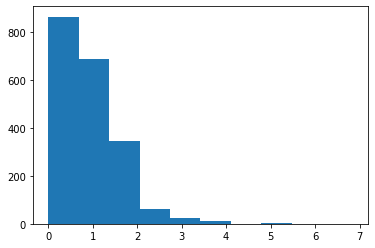

In [11]:
plt.hist(onp.array(onp.squeeze(fid.nodes[0, :, 0])))

(array([  2.,   8.,  12.,  49.,  75., 112., 100.,  79.,  45.,  18.]),
 array([382. , 393.8, 405.6, 417.4, 429.2, 441. , 452.8, 464.6, 476.4,
        488.2, 500. ]),
 <BarContainer object of 10 artists>)

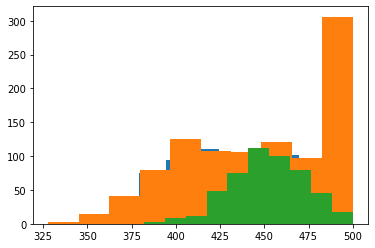

In [12]:
plt.hist(onp.squeeze(onp.array(noisefree_derv.n_node)))
plt.hist(onp.squeeze(onp.array(noisefree_val_derv.n_node)))
plt.hist(onp.squeeze(onp.array(noisefree_fid.n_node)))

setup arguments for noisy sims ! feel free to change below if re-training an IMNN (Colab Pro only)

In [13]:
####### SETUP ARGUMENTS FOR NOISY SIMS [feel free to change !] #######

# make changes below ! 
# ARGS FOR ADDING NOISE ON TOP OF SIMS
# whether or not to do noise
# switch to true for sake of simulation
simulator_args["include_pos"] = False
simulator_args["do_noise"] = True
simulator_args["noise_scale"] = 0.0  # noise amplitude, A_noise. set to 0 for noise-free


# set mass cut again to 1.5
simulator_args['mass_cut'] = 2.0
simulator_args["pad_nodes_to"] = 200
simulator_args["pad_edges_to"] = 450


# then define edge features
r_connect = 0.2     # connection radius
N_int = 2           # number of GNN interaction blocks

num_halos = None    # for variable length inputs
include_mass = True # include mass labels on nodes

In [14]:
_maxedge = onp.max([np.max(noisefree_fid.n_edge), np.max(noisefree_val_fid.n_edge), np.max(noisefree_derv.n_edge), np.max(noisefree_val_derv.n_edge)])
_maxnode = onp.max([np.max(noisefree_fid.n_node), np.max(noisefree_val_fid.n_node), np.max(noisefree_derv.n_node), np.max(noisefree_val_derv.n_node)])

print('max num edges', _maxedge)
print('max num nodes', _maxnode)

max num edges 3744
max num nodes 500


# adding noise: on-the-fly simulator
Here we'll define two functions to add noise to our graphs on-the-fly. Every epoch our network trains we'll add a new noise realization **and catalogue cuts performed on the noisy data**. This will yield differently-lengthed catalogues every time (although the padding will remain the same).


In [15]:
#@title noise simulator code <font color='lightgreen'>[run me]</font>
def seedmatch_getgraph_single(key, graph, r_connect=0.15, 
              num_halos=None, 
              simulator_args=simulator_args):
    num = graph.nodes.shape[0]
    θs = graph.globals
    gs = lambda k,θ,cat: graph_simulator(k, θ, cat, 
                                         simulator_args=simulator_args,
                                         r_connect=r_connect, num_halos=num_halos)
    graph = gs(key, θs, graph.nodes)
    
    return graph

def noise_simulator(key, graph, simulator_args=simulator_args):
    
    return seedmatch_getgraph_single(key, graph, simulator_args["connect_radius"], None, simulator_args)

In [16]:
key = jax.random.PRNGKey(59)

In [17]:
np = jnp
keys = jax.random.split(key, num=n_s)

# vmap over noise-free fiducial simulation
noisyfid = jax.vmap(noise_simulator)(keys, noisefree_fid)

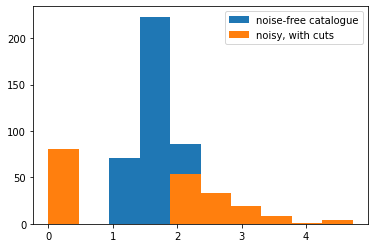

In [18]:
# visualize the two mass cuts
ind = 67 # sim number 67
plt.hist(onp.array(noisefree_fid.nodes[ind, :, 0]), label='noise-free catalogue')
plt.hist(onp.array(noisyfid.nodes[ind, :, 0]), label='noisy, with cuts')
plt.legend()

Here the zeros are just padded, dummy nodes.

# Graph Neural Networks
Here we define our graph neural network architecture. See the paper if you're curious about the architecture ! The key takeaway is: we use neural networks to extract information from padded node $V$ and edge $E$ sets.

In [19]:
#@title graph neural network code in `flax` <font color='lightgreen'>[run me]</font>
from flax import linen as nn
from typing import Any, Callable, Sequence, Optional

import optax

# custom scaling function for large NN inputs
class AsinhLayer(nn.Module):
    bias_init: Callable = nn.initializers.zeros
    a_init: Callable = nn.initializers.ones
    b_init: Callable = nn.initializers.ones
    c_init: Callable = nn.initializers.zeros
    d_init: Callable = nn.initializers.zeros
    
    @nn.compact
    def __call__(self, inputs):

        a = self.param('a', self.a_init, (1,)) #*(1./36)
        b = self.param('b', self.b_init, (1,))
        c = self.param('c', self.c_init, (1,))
        d = self.param('d', self.d_init, (1,)) 

        y = a*jnp.arcsinh(b*inputs + c) + d
        return y

# define activation
act = nn.gelu

# fully-connected network
class ExplicitMLP(nn.Module):
  """A flax MLP."""
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate([nn.Dense(feat) for feat in self.features]):
      x = lyr(x)
      if i != len(self.features) - 1:
        x = act(x)
    return x

# adapt for jraph library -- need wrappers for linen Modules
def make_embed_fn(latent_size):
  def embed(inputs):
    inputs = AsinhLayer()(inputs)
    return nn.Dense(latent_size)(inputs)
  return embed


def make_mlp(features):
  @jraph.concatenated_args
  def update_fn(inputs):
    return ExplicitMLP(features)(inputs)
  return update_fn


# custom mean function for padded inputs
def custom_segment_mean(
                 n_data: int,
                 data: jnp.ndarray,
                 segment_ids: jnp.ndarray,
                 num_segments: Optional[int] = None,
                 indices_are_sorted: bool = False,
                 unique_indices: bool = False):
  """Returns mean for each segment.
  Args:
    n_data: the number of data we want to take the mean of
    data: the values which are averaged segment-wise.
    segment_ids: indices for the segments.
    num_segments: total number of segments.
    indices_are_sorted: whether ``segment_ids`` is known to be sorted.
    unique_indices: whether ``segment_ids`` is known to be free of duplicates.
  """
  denom = n_data
  nominator = jraph.segment_sum(
      data,
      segment_ids,
      num_segments,
      indices_are_sorted=indices_are_sorted,
      unique_indices=unique_indices)
  denominator = jraph.segment_sum(
      jnp.ones_like(data),
      segment_ids,
      num_segments,
      indices_are_sorted=indices_are_sorted,
      unique_indices=unique_indices)
  return nominator / jnp.maximum(denom,
                                 jnp.ones(shape=[], dtype=denominator.dtype))

# custom variance function for padded inputs
def custom_segment_variance(n_data: int,
                     data: jnp.ndarray,
                     segment_ids: jnp.ndarray,
                     num_segments: Optional[int] = None,
                     indices_are_sorted: bool = False,
                     unique_indices: bool = False):
  """Returns the variance for each segment.
  Args:
    n_data: the number of data we want to take the variance of
    data: values whose variance will be calculated segment-wise.
    segment_ids: indices for segments
    num_segments: total number of segments.
    indices_are_sorted: whether ``segment_ids`` is known to be sorted.
    unique_indices: whether ``segment_ids`` is known to be free of duplicates.
  Returns:
    num_segments size array containing the variance of each segment.
  """
  means = custom_segment_mean(
      n_data,
      data,
      segment_ids,
      num_segments,
      indices_are_sorted=indices_are_sorted,
      unique_indices=unique_indices)[segment_ids]
  counts = jraph.segment_sum(
      jnp.ones_like(data),
      segment_ids,
      num_segments,
      indices_are_sorted=indices_are_sorted,
      unique_indices=unique_indices)
  
  counts = n_data*jnp.ones_like(counts)
  counts = jnp.maximum(counts, jnp.ones_like(counts))

  variances = jraph.segment_sum(
      jnp.power(data - means, 2),
      segment_ids,
      num_segments,
      indices_are_sorted=indices_are_sorted,
      unique_indices=unique_indices) / counts
  return variances

# custom aggregation function
def custom_aggregation(n_data: int,
                     data: jnp.ndarray,
                     segment_ids: jnp.ndarray,
                     num_segments: Optional[int] = None,
                     indices_are_sorted: bool = False,
                     unique_indices: bool = False):
    """Returns the variance for each segment.
      Args:
        n_data: the number of data we want to take the variance of
        data: values whose variance will be calculated segment-wise.
        segment_ids: indices for segments
        num_segments: total number of segments.
        indices_are_sorted: whether ``segment_ids`` is known to be sorted.
        unique_indices: whether ``segment_ids`` is known to be free of duplicates.
      Returns:
        (num_segments, 4) size array containing the [sum, mean, variance, max]
        of input data.
    """
    
    
    variance = custom_segment_variance(n_data=n_data,
                     data=data,
                     segment_ids=segment_ids,
                     num_segments=num_segments,
                     indices_are_sorted=indices_are_sorted,
                     unique_indices=unique_indices)
    
    mean = custom_segment_mean(n_data=n_data,
                     data=data,
                     segment_ids=segment_ids,
                     num_segments=num_segments,
                     indices_are_sorted=indices_are_sorted,
                     unique_indices=unique_indices)
    
    _max = jraph.segment_max(
                     data=data,
                     segment_ids=segment_ids,
                     num_segments=num_segments,
                     indices_are_sorted=indices_are_sorted,
                     unique_indices=unique_indices)   
        
    _sum = jraph.segment_sum(
                     data=data,
                     segment_ids=segment_ids,
                     num_segments=num_segments,
                     indices_are_sorted=indices_are_sorted,
                     unique_indices=unique_indices)
    
    return jnp.concatenate([_sum, mean, variance, _max], axis=-1)


class flaxGraphNetwork(nn.Module):
  """A flax GraphNetwork."""
  mlp_features: Sequence[int]
  latent_size: int
  decorate_nodes: bool=False
  remove_vel: bool=False
  num_nets: int=1
  remove_edges: bool=False

  @nn.compact
  def __call__(self, graph):

    _nodes = graph.nodes
    
    if not self.decorate_nodes:
        # the indicator functions are here represented by the edge
        # sender and receiver indexes, so we are free to set all nodes
        # to zero.
        _nodes = _nodes.at[:, 0:4].set(0.)

    # in this study we don't consider velocity
    if self.remove_vel:
        _nodes = _nodes.at[:, 1:4].set(0.)
    
    # whether or not to remove edge labels. here always False.
    if self.remove_edges:
        graph = graph._replace(edges=jnp.zeros(graph.edges.shape))
    
    # replaces graph features with desired masked elements.
    # add N^v and N^e as global properties
    graph = graph._replace(
                           globals=jnp.vstack([jnp.arcsinh(graph.n_node), jnp.arcsinh(graph.n_edge)]).reshape(1,-1),
                           senders=graph.senders.astype(int),
                           receivers=graph.senders.astype(int),
                           n_node = graph.n_node.reshape(-1,1),
                           nodes=_nodes)

    embedder = jraph.GraphMapFeatures(
        embed_node_fn=make_embed_fn(self.latent_size),
        embed_edge_fn=make_embed_fn(self.latent_size),
        embed_global_fn=make_embed_fn(self.latent_size))
    
    # rho aggregation functions
    aggregate_nodes_for_globals_fn = lambda d,s,n: jnp.arcsinh(custom_aggregation(jnp.squeeze(graph.n_node), d,s,n))
    aggregate_edges_for_nodes_fn = jraph.segment_sum #lambda d,s,n: jnp.arcsinh(jraph.segment_sum(d,s,n))
    aggregate_edges_for_globals_fn = lambda d,s,n: jnp.arcsinh(custom_aggregation(jnp.squeeze(graph.n_edge), d,s,n))
    
    update_node_fn = make_mlp(self.mlp_features)
    update_edge_fn = make_mlp(self.mlp_features)

    # first embed the graph features to a higher dimensionality
    graph = embedder(graph)
    
    # then pass through N^int interaction GNN blocks
    for i in range(self.num_nets):
        if i == self.num_nets-1:
            feats = self.mlp_features + (n_params,)
        else:
            feats = self.mlp_features
            
        net = jraph.GraphNetwork(
            update_node_fn=make_mlp(self.mlp_features),
            update_edge_fn=make_mlp(self.mlp_features),
            aggregate_edges_for_nodes_fn=aggregate_edges_for_nodes_fn,
            aggregate_nodes_for_globals_fn=aggregate_nodes_for_globals_fn,
            aggregate_edges_for_globals_fn=aggregate_edges_for_globals_fn,
            update_global_fn=make_mlp(feats))
        
        graph = net(graph)

    # return global properties (gIMNN summaries)
    return graph.globals.reshape(-1)

In [20]:
# load a dummy graph for initializing the model -- no noise needed here
foo = load_graph_attributes(folder=graphdir, name='lc_eq_fid/')
graph = padded_graph_builder(foo.nodes[0], θ_fid, simulator_args,\
                                  r_connect=r_connect)

loading from /data80/makinen/quijote/graphs/png/z_1/lc_eq_fid/


initialize the graph network with a dummy input

In [21]:
key = jax.random.PRNGKey(22)
model = flaxGraphNetwork([50, 50], 50, decorate_nodes=include_mass, remove_vel=True, num_nets=N_int, remove_edges=False)
initial_w = model.init(key, graph)
output1 = model.apply(initial_w, graph)

In [22]:
np = jnp

In [23]:
#@title imnn utils <font color='lightgreen'>[run me]</font>
def _check_input(input, shape, name, allow_None=False):
    """Exception raising checks for numpy array shapes

    Checks whether input is not ``None`` and if not checks that the input is a
    jax numpy array and if not raises a warning. If the input is a jax numpy
    array it then checks the shape is the same as the required shape.

    Can also allow ``None`` to be passed if it input is not essential.

    Parameters
    ----------
    input: any
        The input parameter to be checked
    shape: tuple
        The shape that the input is required to be
    name: str
        The name of the variable for printing explicit errors in ``Exception``
    allow_None: bool, default=False
        Whether a ``None`` input can be returned as None without raising error

    Returns
    -------
    array
        Returns the input if all checks pass

    Raises
    ------
    ValueError
        If input is None
    ValueError
        If input shape is incorrect
    TypeError
        If input is not a jax array
    """
    if (input is None) and (not allow_None):
        raise ValueError(f"`{name}` is None")
    elif (input is None) and allow_None:
        return input
    # elif not isinstance(
    #         input, (jax.interpreters.xla.device_array, np.ndarray)):
    #     raise TypeError(f"`{name}` must be a jax array")
    else:
        if input.shape != shape:
            raise ValueError(f"`{name}` should have shape {shape} but has " +
                             f"{input.shape}")
    return input

In [24]:
#@title modified IMNN module <font color='lightgreen'>[run me]</font>
import math
import jax
import optax
import matplotlib.pyplot as plt
from functools import partial
from imnn.utils.utils import _check_boolean, _check_type, \
    _check_model, _check_model_output, _check_optimiser, _check_state, \
    _check_statistics_set
from imnn.experimental import progress_bar

np = jnp

class _myIMNN:
    """Information maximising neural network parent class

    This class defines the general fitting framework for information maximising
    neural networks. It includes the generic calculations of the Fisher
    information matrix from the outputs of a neural network as well as an XLA
    compilable fitting routine (with and without a progress bar). This class
    also provides a plotting routine for fitting history and a function to
    calculate the score compression of network outputs to quasi-maximum
    likelihood estimates of model parameter values.

    The outline of the fitting procedure is that a set of :math:`i\\in[1, n_s]`
    simulations and :math:`n_d` derivatives with respect to physical model
    parameters are used to calculate network outputs and their derivatives
    with respect to the physical model parameters, :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha`, where
    :math:`\\alpha` labels the physical parameter. The exact details of how
    these are calculated depend on the type of available data (see list of
    different IMNN below). With :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha` the covariance

    .. math::
        C_{ab} = \\frac{1}{n_s-1}\\sum_{i=1}^{n_s}(x^i_a-\\mu^i_a)
        (x^i_b-\\mu^i_b)

    and the derivative of the mean of the network outputs with respect to the
    model parameters

    .. math::
        \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha} = \\frac{1}{n_d}
        \\sum_{i=1}^{n_d}\\frac{\\partial{x^i_a}}{\\partial\\theta_\\alpha}

    can be calculated and used form the Fisher information matrix

    .. math::
        F_{\\alpha\\beta} = \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha}
        C^{-1}_{ab}\\frac{\\partial\\mu_b}{\\partial\\theta_\\beta}.

    The loss function is then defined as

    .. math::
        \\Lambda = -\\log|{\\bf F}| + r(\\Lambda_2) \\Lambda_2

    Since any linear rescaling of a sufficient statistic is also a sufficient
    statistic the negative logarithm of the determinant of the Fisher
    information matrix needs to be regularised to fix the scale of the network
    outputs. We choose to fix this scale by constraining the covariance of
    network outputs as

    .. math::
        \\Lambda_2 = ||{\\bf C}-{\\bf I}|| + ||{\\bf C}^{-1}-{\\bf I}||

    Choosing this constraint is that it forces the covariance to be
    approximately parameter independent which justifies choosing the covariance
    independent Gaussian Fisher information as above. To avoid having a dual
    optimisation objective, we use a smooth and dynamic regularisation strength
    which turns off the regularisation to focus on maximising the Fisher
    information when the covariance has set the scale

    .. math::
        r(\\Lambda_2) = \\frac{\\lambda\\Lambda_2}{\\Lambda_2-\\exp
        (-\\alpha\\Lambda_2)}.

    Once the loss function is calculated the automatic gradient is then
    calculated and used to update the network parameters via the optimiser
    function. Note for large input data-sizes, large :math:`n_s` or massive
    networks the gradients may need manually accumulating via the
    :func:`~imnn.imnn._aggregated_imnn._AggregatedIMNN`.

    ``_IMNN`` is designed as the parent class for a range of specific case
    IMNNs. There is a helper function (IMNN) which should return the correct
    case when provided with the correct data. These different subclasses are:

    :func:`~imnn.SimulatorIMNN`:

        Fit an IMNN using simulations generated on-the-fly from a jax (XLA
        compilable) simulator

    :func:`~imnn.GradientIMNN`:

        Fit an IMNN using a precalculated set of fiducial simulations and their
        derivatives with respect to model parameters

    :func:`~imnn.NumericalGradientIMNN`:

        Fit an IMNN using a precalculated set of fiducial simulations and
        simulations generated using parameter values just above and below the
        fiducial parameter values to make a numerical estimate of the
        derivatives of the network outputs. Best stability is achieved when
        seeds of the simulations are matched between all parameter directions
        for the numerical derivative

    :func:`~imnn.AggregatedSimulatorIMNN`:

        ``SimulatorIMNN`` distributed over multiple jax devices and gradients
        aggregated manually. This might be necessary for very large input sizes
        as batching cannot be done when calculating the Fisher information
        matrix

    :func:`~imnn.AggregatedGradientIMNN`:

        ``GradientIMNN`` distributed over multiple jax devices and gradients
        aggregated manually. This might be necessary for very large input sizes
        as batching cannot be done when calculating the Fisher information
        matrix

    :func:`~imnn.AggregatedNumericalGradientIMNN`:

        ``NumericalGradientIMNN`` distributed over multiple jax devices and
        gradients aggregated manually. This might be necessary for very large
        input sizes as batching cannot be done when calculating the Fisher
        information matrix

    :func:`~imnn.DatasetGradientIMNN`:

        ``AggregatedGradientIMNN`` with prebuilt TensorFlow datasets

    :func:`~imnn.DatasetNumericalGradientIMNN`:

        ``AggregatedNumericalGradientIMNN`` with prebuilt TensorFlow datasets

    There are currently two other parent classes

    :func:`~imnn.imnn._aggregated_imnn.AggregatedIMNN`:

        This is the parent class which provides the fitting routine when the
        gradients of the network parameters are aggregated manually rather than
        automatically by jax. This is necessary if the size of an entire batch
        of simulations (and their derivatives with respect to model parameters)
        and the network parameters and their calculated gradients is too large
        to fit into memory. Note there is a significant performance loss from
        using the aggregation so it should only be used for these large data
        cases

    Parameters
    ----------
    n_s : int
        Number of simulations used to calculate network output covariance
    n_d : int
        Number of simulations used to calculate mean of network output
        derivative with respect to the model parameters
    n_params : int
        Number of model parameters
    n_summaries : int
        Number of summaries, i.e. outputs of the network
    input_shape : tuple
        The shape of a single input to the network
    θ_fid : float(n_params,)
        The value of the fiducial parameter values used to generate inputs
    validate : bool
        Whether a validation set is being used
    simulate : bool
        Whether input simulations are generated on the fly
    _run_with_pbar : bool
        Book keeping parameter noting that a progress bar is used when
        fitting (induces a performance hit). If ``run_with_pbar = True``
        and ``run_without_pbar = True`` then a jit compilation error will
        occur and so it is prevented
    _run_without_pbar : bool
        Book keeping parameter noting that a progress bar is not used when
        fitting. If ``run_with_pbar = True`` and ``run_without_pbar = True``
        then a jit compilation error will occur and so it is prevented
    F : float(n_params, n_params)
        Fisher information matrix calculated from the network outputs
    invF : float(n_params, n_params)
        Inverse Fisher information matrix calculated from the network outputs
    C : float(n_summaries, n_summaries)
        Covariance of the network outputs
    invC : float(n_summaries, n_summaries)
        Inverse covariance of the network outputs
    μ : float(n_summaries,)
        Mean of the network outputs
    dμ_dθ : float(n_summaries, n_params)
        Derivative of the mean of the network outputs with respect to model
        parameters
    state : :obj:state
        The optimiser state used for updating the network parameters and
        optimisation algorithm
    initial_w : list
        List of the network parameters values at initialisation (to restart)
    final_w : list
        List of the network parameters values at the end of fitting
    best_w : list
        List of the network parameters values which provide the maxmimum value
        of the determinant of the Fisher matrix
    w : list
        List of the network parameters values (either final or best depending
        on setting when calling fit(...))
    history : dict
        A dictionary containing the fitting history. Keys are
            - **detF** -- determinant of the Fisher information at the end of
              each iteration
            - **detC** -- determinant of the covariance of network outputs at
              the end of each iteration
            - **detinvC** -- determinant of the inverse covariance of network
              outputs at the end of each iteration
            - **Λ2** -- value of the covariance regularisation at the end of
              each iteration
            - **r** -- value of the regularisation coupling at the end of each
              iteration
            - **val_detF** -- determinant of the Fisher information of the
              validation data at the end of each iteration
            - **val_detC** -- determinant of the covariance of network outputs
              given the validation data at the end of each iteration
            - **val_detinvC** -- determinant of the inverse covariance of
              network outputs given the validation data at the end of each
              iteration
            - **val_Λ2** -- value of the covariance regularisation given the
              validation data at the end of each iteration
            - **val_r** -- value of the regularisation coupling given the
              validation data at the end of each iteration
            - **max_detF** -- maximum value of the determinant of the Fisher
              information on the validation data (if available)

    Methods
    -------
    model:
        Neural network as a function of network parameters and inputs
    _get_parameters:
        Function which extracts the network parameters from the state
    _model_initialiser:
        Function to initialise neural network weights from RNG and shape tuple
    _opt_initialiser:
        Function which generates the optimiser state from network parameters
    _update:
        Function which updates the state from a gradient

    Todo
    ----
    - Finish all docstrings and documentation
    - Update `NoiseNumericalGradientIMNN` to inherit from `_AggregatedIMNN`

    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, dummy_input=None, no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all _IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float([None], input_shape)) -> float([None],
            n_summaries)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        dummy_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        self.dummy_input=dummy_input
        self._initialise_parameters(
            n_s, n_d, n_params, n_summaries, input_shape, θ_fid)
        self._initialise_model(model, optimiser, key_or_state)
        self._initialise_history()
        self.no_invC=no_invC
        self.do_reg=do_reg
        self.evidence=evidence


    def _initialise_parameters(self, n_s, n_d, n_params, n_summaries,
                               input_shape, θ_fid):
        """Performs type checking and initialisation of class attributes

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs

        Raises
        ------
        TypeError
            Any of the parameters are not correct type
        ValueError
            Any of the parameters are ``None``
            ``Θ_fid`` has the wrong shape
        """
        self.n_s = _check_type(n_s, int, "n_s")
        self.n_d = _check_type(n_d, int, "n_d")
        self.n_params = _check_type(n_params, int, "n_params")
        self.n_summaries = _check_type(n_summaries, int, "n_summaries")
        self.input_shape = _check_type(input_shape, tuple, "input_shape")
        self.θ_fid = _check_input(θ_fid, (self.n_params,), "θ_fid")

        self.validate = False
        self.simulate = False
        self._run_with_pbar = False
        self._run_without_pbar = False

        self.F = None
        self.invF = None
        self.C = None
        self.invC = None
        self.μ = None
        self.dμ_dθ = None

        self._model_initialiser = None
        self.model = None
        self._opt_initialiser = None
        self._update = None
        self._get_parameters = None
        self.state = None
        self.initial_w = None
        self.final_w = None
        self.best_w = None
        self.w = None

        self.history = None

    def _initialise_model(self, model, optimiser, key_or_state):
        """Initialises neural network parameters or loads optimiser state

        Parameters
        ----------
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and
            the neural network as a function of network parameters and inputs
            ``fn(w: list, d: float([None], input_shape)) -> float([None],
            n_summaries)``. (Essentibly stax-like, see `jax.experimental.stax
            <https://jax.readthedocs.io/en/stable/jax.experimental.stax.html>`_
            ))
        optimiser : tuple or obj, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser

        Notes
        -----
        The design of the model follows `jax's stax module <https://jax.readth
        edocs.io/en/latest/jax.experimental.stax.html>`_ in that the model is
        encapsulated by two functions, one to initialise the network and one to
        call the model, i.e.::

            import jax
            from jax.experimental import stax

            rng = jax.random.PRNGKey(0)

            data_key, model_key = jax.random.split(rng)

            input_shape = (10,)
            inputs = jax.random.normal(data_key, shape=input_shape)

            model = stax.serial(
                stax.Dense(10),
                stax.LeakyRelu,
                stax.Dense(10),
                stax.LeakyRelu,
                stax.Dense(2))

            output_shape, initial_params = model[0](model_key, input_shape)

            outputs = model[1](initial_params, inputs)

        Note that the model used in the IMNN is assumed to be totally
        broadcastable, i.e. any batch shape can be used for inputs. This might
        require having a layer which reshapes all batch dimensions into a
        single dimension and then unwraps it at the last layer. A model such as
        that above is already fully broadcastable.

        The optimiser should follow `jax's experimental optimiser module <http
        s://jax.readthedocs.io/en/stable/jax.experimental.optimizers.html>`_ in
        that the optimiser is encapsulated by three functions, one to
        initialise the state, one to update the state from a list of gradients
        and one to extract the network parameters from the state, .i.e

        .. code-block:: python

            from jax.experimental import optimizers
            import jax.numpy as np

            optimiser = optimizers.adam(step_size=1e-3)

            initial_state = optimiser[0](initial_params)
            params = optimiser[2](initial_state)

            def scalar_output(params, inputs):
                return np.sum(model[1](params, inputs))

            counter = 0
            grad = jax.grad(scalar_output, argnums=0)(params, inputs)
            state = optimiser[1](counter, grad, state)

        This function either initialises the neural network or the state if
        passed a stateless random number generator in ``key_or_state`` or loads
        a predefined state if the state is passed to ``key_or_state``. The
        functions get mapped to the class functions

        .. code-block:: python

            self.model = model[1]
            self._model_initialiser = model[0]

            self._opt_initialiser = optimiser[0]
            self._update = optimiser[1]
            self._get_parameters = optimiser[2]

        The state is made into the ``state`` class attribute and the parameters
        are assigned to ``initial_w``, ``final_w``, ``best_w`` and ``w`` class
        attributes (where ``w`` stands for weights).

        There is some type checking done, but for freedom of choice of model
        there will be very few raised warnings.

        Raises
        ------
        TypeError
            If the random number generator is not correct, or if there is no
            possible way to construct a model or an optimiser from the passed
            parameters
        ValueError
            If any input is ``None`` or if the functions for the model or
            optimiser do not conform to the necessary specifications
        """

        # initialize FLAX model here
        self._model_initialiser = model.init
        self.model = model.apply

        # unpack optimiser
        self._opt_initialiser, self._update = optimiser

        #state, key = _check_state(key_or_state)
        key = key_or_state

        if key is not None:
            key = _check_input(key, (2,), "key_or_state")
            if self.dummy_input is None:
                dummy_x = jax.random.uniform(key, self.input_shape)
            else:
                dummy_x = self.dummy_input

            # INITIAL PARAMS
            self.initial_w = self._model_initialiser(key, dummy_x)
            
            # DUMMY OUTPUT
            output = self.model(self.initial_w, dummy_x)
            # check to see if right shape
            _check_model_output(output.shape, (self.n_summaries,))
            # INITIAL STATE
            self.state = self._opt_initialiser(self.initial_w)


        else:
            self.state = state
            try:
                self._get_parameters(self.state)
            except Exception:
                raise TypeError("`state` is not valid for extracting " +
                                "parameters from")

        self.dummy_x = dummy_x
        self.initial_w = self._model_initialiser(key, dummy_x)
        self.final_w = self._model_initialiser(key, dummy_x)
        self.best_w = self._model_initialiser(key, dummy_x)
        self.w = self._model_initialiser(key, dummy_x)


    def _initialise_history(self):
        """Initialises history dictionary attribute

        Notes
        -----
        The contents of the history dictionary are
            - **detF** -- determinant of the Fisher information at the end of
              each iteration
            - **detC** -- determinant of the covariance of network outputs at
              the end of each iteration
            - **detinvC** -- determinant of the inverse covariance of network
              outputs at the end of each iteration
            - **Λ2** -- value of the covariance regularisation at the end of
              each iteration
            - **r** -- value of the regularisation coupling at the end of each
              iteration
            - **val_detF** -- determinant of the Fisher information of the
              validation data at the end of each iteration
            - **val_detC** -- determinant of the covariance of network outputs
              given the validation data at the end of each iteration
            - **val_detinvC** -- determinant of the inverse covariance of
              network outputs given the validation data at the end of each
              iteration
            - **val_Λ2** -- value of the covariance regularisation given the
              validation data at the end of each iteration
            - **val_r** -- value of the regularisation coupling given the
              validation data at the end of each iteration
            - **max_detF** -- maximum value of the determinant of the Fisher
              information on the validation data (if available)

        """
        self.history = {
            "detF": np.zeros((0,)),
            "detC": np.zeros((0,)),
            "detinvC": np.zeros((0,)),
            "Λ2": np.zeros((0,)),
            "r": np.zeros((0,)),
            "val_detF": np.zeros((0,)),
            "val_detC": np.zeros((0,)),
            "val_detinvC": np.zeros((0,)),
            "val_Λ2": np.zeros((0,)),
            "val_r": np.zeros((0,)),
            "max_detF": np.float32(0.)
        }

    def _set_history(self, results):
        """Places results from fitting into the history dictionary

        Parameters
        ----------
        results : list
            List of results from fitting procedure. These are:
                - **detF** *(float(n_iterations, 2))* -- determinant of the
                  Fisher information, ``detF[:, 0]`` for training and
                  ``detF[:, 1]`` for validation
                - **detC** *(float(n_iterations, 2))* -- determinant of the
                  covariance of network outputs, ``detC[:, 0]`` for training
                  and ``detC[:, 1]`` for validation
                - **detinvC** *(float(n_iterations, 2))* -- determinant of the
                  inverse covariance of network outputs, ``detinvC[:, 0]`` for
                  training and ``detinvC[:, 1]`` for validation
                - **Λ2** *(float(n_iterations, 2))* -- value of the covariance
                  regularisation, ``Λ2[:, 0]`` for training and ``Λ2[:, 1]``
                  for validation
                - **r** *(float(n_iterations, 2))* -- value of the
                  regularisation coupling, ``r[:, 0]`` for training and
                  ``r[:, 1]`` for validation

        """
        keys = ["detF", "detC", "detinvC", "Λ2", "r"]
        for result, key in zip(results, keys):
            self.history[key] = np.hstack([self.history[key], result[:, 0]])
            if self.validate:
                self.history[f"val_{key}"] = np.hstack(
                    [self.history[f"val_{key}"], result[:, 1]])

    def _set_inputs(self, rng, max_iterations):
        """Builds list of inputs for the XLA compilable fitting routine

        Parameters
        ----------
        rng : int(2,) or None
            A stateless random number generator
        max_iterations : int
            Maximum number of iterations to run the fitting procedure for

        Notes
        -----
        The list of inputs to the routine are
            - **max_detF** *(float)* -- The maximum value of the determinant of
              the Fisher information matrix calculated so far. This is zero if
              not run before or the value from previous calls to ``fit``
            - **best_w** *(list)* -- The value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix. This is the initial network parameter values if not run
              before
            - **detF** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the Fisher information matrix during each
              iteration of fitting. If there is no validation (for simulation
              on-the-fly for example) then this container has a shape of
              ``(max_iterations, 1)``, otherwise validation values are stored
              in ``detF[:, 1]``.
            - **detC** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the covariance of network outputs during
              each iteration of fitting. If there is no validation (for
              simulation on-the-fly for example) then this container has a
              shape of ``(max_iterations, 1)``, otherwise validation values are
              stored in ``detC[:, 1]``.
            - **detF** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the inverse covariance of network outputs
              during each iteration of fitting. If there is no validation (for
              simulation on-the-fly for example) then this container has a
              shape of ``(max_iterations, 1)``, otherwise validation values are
              stored in ``detinvC[:, 1]``.
            - **Λ2** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the covariance regularisation during each iteration of
              fitting. If there is no validation (for simulation on-the-fly for
              example) then this container has a shape of
              ``(max_iterations, 1)``, otherwise validation values are stored
              in ``Λ2[:, 1]``.
            - **r** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the regularisation coupling strength during each iteration of
              fitting. If there is no validation (for simulation on-the-fly for
              example) then this container has a shape of
              ``(max_iterations, 1),`` otherwise validation values are stored
              in ``r[:, 1]``.
            - **counter** *(int)* -- Iteration counter used to note whether the
              while loop reaches ``max_iterations``. If not, the history
              objects (above) get truncated to length ``counter``. This starts
              with value zero
            - **patience_counter** *(int)* -- Counts the number of iterations
              where there is no increase in the value of the determinant of the
              Fisher information matrix, used for early stopping. This starts
              with value zero
            - **state** *(:obj:state)* -- The current optimiser state used for
              updating the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- A stateless random number generator which
              gets updated on each iteration

        Todo
        ----
        ``rng`` is currently only used for on-the-fly simulation but could
        easily be updated to allow for stochastic models
        """
        if self.validate:
            shape = (max_iterations, 2)
        else:
            shape = (max_iterations, 1)

        return (
            self.history["max_detF"], self.best_w, np.zeros(shape),
            np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape),
            np.int32(0), np.int32(0), self.state, self.w, rng)

    def fit(self, λ, ϵ, γ=1000., rng=None, patience=100, min_iterations=100,
            max_iterations=int(1e5), print_rate=None, best=True):
        """Fitting routine for the IMNN

        Parameters
        ----------
        λ : float
            Coupling strength of the regularisation
        ϵ : float
            Closeness criterion describing how close to the 1 the determinant
            of the covariance (and inverse covariance) of the network outputs
            is desired to be
        rng : int(2,) or None, default=None
            Stateless random number generator
        patience : int, default=10
            Number of iterations where there is no increase in the value of the
            determinant of the Fisher information matrix, used for early
            stopping
        min_iterations : int, default=100
            Number of iterations that should be run before considering early
            stopping using the patience counter
        max_iterations : int, default=int(1e5)
            Maximum number of iterations to run the fitting procedure for
        print_rate : int or None, default=None,
            Number of iterations before updating the progress bar whilst
            fitting. There is a performance hit from updating the progress bar
            more often and there is a large performance hit from using the
            progress bar at all. (Possible ``RET_CHECK`` failure if
            ``print_rate`` is not ``None`` when using GPUs).
            For this reason it is set to None as default
        best : bool, default=True
            Whether to set the network parameter attribute ``self.w`` to the
            parameter values that obtained the maximum determinant of
            the Fisher information matrix or the parameter values at the final
            iteration of fitting

        Example
        -------

        We are going to summarise the mean and variance of some random Gaussian
        noise with 10 data points per example using a SimulatorIMNN. In this
        case we are going to generate the simulations on-the-fly with a
        simulator written in jax (from the examples directory). We will use
        1000 simulations to estimate the covariance of the network outputs and
        the derivative of the mean of the network outputs with respect to the
        model parameters (Gaussian mean and variance) and generate the
        simulations at a fiducial μ=0 and Σ=1. The network will be a stax model
        with hidden layers of ``[128, 128, 128]`` activated with leaky relu and
        outputting 2 summaries. Optimisation will be via Adam with a step size
        of ``1e-3``. Rather arbitrarily we'll set the regularisation strength
        and covariance identity constraint to λ=10 and ϵ=0.1 (these are
        relatively unimportant for such an easy model).

        .. code-block:: python

            import jax
            import jax.numpy as np
            from jax.experimental import stax, optimizers
            from imnn import SimulatorIMNN

            rng = jax.random.PRNGKey(0)

            n_s = 1000
            n_d = 1000
            n_params = 2
            n_summaries = 2
            input_shape = (10,)
            simulator_args = {"input_shape": input_shape}
            θ_fid = np.array([0., 1.])

            def simulator(rng, θ):
                return θ[0] + jax.random.normal(
                    rng, shape=input_shape) * np.sqrt(θ[1])

            model = stax.serial(
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(n_summaries))
            optimiser = optimizers.adam(step_size=1e-3)

            λ = 10.
            ϵ = 0.1

            model_key, fit_key = jax.random.split(rng)

            imnn = SimulatorIMNN(
                n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
                input_shape=input_shape, θ_fid=θ_fid, model=model,
                optimiser=optimiser, key_or_state=model_key,
                simulator=simulator)

            imnn.fit(λ, ϵ, rng=fit_key, min_iterations=1000, patience=250,
                     print_rate=None)


        Notes
        -----
        A minimum number of interations should be be run before stopping based
        on a maximum determinant of the Fisher information achieved since the
        loss function has dual objectives. Since the determinant of the
        covariance of the network outputs is forced to 1 quickly, this can be
        at the detriment to the value of the determinant of the Fisher
        information matrix early in the fitting procedure. For this reason
        starting early stopping after the covariance has converged is advised.
        This is not currently implemented but could be considered in the
        future.

        The best fit network parameter values are probably not the most
        representative set of parameters when simulating on-the-fly since there
        is a high chance of a statistically overly-informative set of data
        being generated. Instead, if using :func:`~imnn.SimulatorIMNN.fit()`
        consider using ``best=False`` which sets ``self.w=self.final_w`` which
        are the network parameter values obtained in the last iteration. Also
        consider using a larger ``patience`` value if using
        :func:`~imnn.SimulatorIMNN.fit()` to overcome the fact that a flukish
        high value for the determinant might have been obtained due to the
        realisation of the dataset.

        Due to some unusual thing, that I can't work out, there is a massive
        performance hit when calling ``jax.jit(self._fit)`` compared with
        directly decorating ``_fit`` with
        ``@partial(jax.jit(static_argnums=0))``. Unfortunately this means
        having to duplicate ``_fit`` to include a version where the loop
        condition is decorated with a progress bar because the ``tqdm``
        module cannot use a jitted tracer. If the progress bar is not used then
        the fully decorated jitted ``_fit`` function is used and it is super
        quick. Otherwise, just the body of the loop is jitted so that the
        condition function can be decorated by the progress bar (at the
        expense of a performance hit). I imagine that something can be improved
        here.

        There is a chance of a ``RET_CHECK`` failure when using the progress
        bar on GPUs (this doesn't seem to be a problem on CPUs). If this is the
        case then `print_rate=None` should be used

        Methods
        -------
        _fit:
            Main fitting function implemented as a ``jax.lax.while_loop``
        _fit_pbar:
            Main fitting function as a ``jax.lax.while_loop`` with progress bar

        Raises
        ------
        TypeError
            If any input has the wrong type
        ValueError
            If any input (except ``rng`` and ``print_rate``) are ``None``
        ValueError
            If ``rng`` has the wrong shape
        ValueError
            If ``rng`` is ``None`` but simulating on-the-fly
        ValueError
            If calling fit with ``print_rate=None`` after previous call with
            ``print_rate`` as an integer value
        ValueError
            If calling fit with ``print_rate`` as an integer after previous
            call with ``print_rate=None``

        Todo
        ----
        - ``rng`` is currently only used for on-the-fly simulation but could
          easily be updated to allow for stochastic models
        - Automatic detection of convergence based on value ``r`` when early
          stopping can be started
        """

        @jax.jit
        def _fit(inputs):

            return jax.lax.while_loop(
                partial(self._fit_cond, patience=patience,
                        max_iterations=max_iterations),
                partial(self._fit, λ=λ, α=α, γ=γ, min_iterations=min_iterations),
                inputs)

        def _fit_pbar(inputs):

            return jax.lax.while_loop(
                progress_bar(max_iterations, patience, print_rate)(
                    partial(self._fit_cond, patience=patience,
                            max_iterations=max_iterations)),
                jax.jit(
                    partial(self._fit, λ=λ, α=α,
                            min_iterations=min_iterations)),
                inputs)

        λ = _check_type(λ, float, "λ")
        ϵ = _check_type(ϵ, float, "ϵ")
        γ = _check_type(γ, float, "γ")
        α = self.get_α(λ, ϵ)
        patience = _check_type(patience, int, "patience")
        min_iterations = _check_type(min_iterations, int, "min_iterations")
        max_iterations = _check_type(max_iterations, int, "max_iterations")
        best = _check_boolean(best, "best")
        if self.simulate and (rng is None):
            raise ValueError("`rng` is necessary when simulating.")
        rng = _check_input(rng, (2,), "rng", allow_None=True)
        inputs = self._set_inputs(rng, max_iterations)
        if print_rate is None:
            if self._run_with_pbar:
                raise ValueError(
                    "Cannot run IMNN without progress bar after running " +
                    "with progress bar. Either set `print_rate` to an int " +
                    "or reinitialise the IMNN.")
            else:
                self._run_without_pbar = True
                results = _fit(inputs)
        else:
            if self._run_without_pbar:
                raise ValueError(
                    "Cannot run IMNN with progress bar after running " +
                    "without progress bar. Either set `print_rate` to None " +
                    "or reinitialise the IMNN.")
            else:
                print_rate = _check_type(print_rate, int, "print_rate")
                self._run_with_pbar = True
                results = _fit_pbar(inputs)
        self.history["max_detF"] = results[0]
        self.best_w = results[1]
        self._set_history(
            (results[2][:results[7]],
             results[3][:results[7]],
             results[4][:results[7]],
             results[5][:results[7]],
             results[6][:results[7]]))
        if len(results) == 12:
            self.state = results[-3]
        self.final_w = results[-2] #self._get_parameters(self.state)
        if best:
            w = self.best_w
        else:
            w = self.final_w
        self.set_F_statistics(w, key=rng)

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation generation if needed

        Parameters
        ----------
        rng : int(2,) or None
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,) or None, None, None:
            A new random number generator and random number generators for
            training and validation, or empty values
        """
        if rng is not None:
            return jax.random.split(rng, num=3)
        else:
            return None, None, None

    def get_α(self, λ, ϵ):
        """Calculate rate parameter for regularisation from closeness criterion

        Parameters
        ----------
        λ : float
            coupling strength of the regularisation
        ϵ : float
            closeness criterion describing how close to the 1 the determinant
            of the covariance (and inverse covariance) of the network outputs
            is desired to be

        Returns
        -------
        float:
            The steepness of the tanh-like function (or rate) which determines
            how fast the determinant of the covariance of the network outputs
            should be pushed to 1
        """
        return - math.log(ϵ * (λ - 1.) + ϵ ** 2. / (1 + ϵ)) / ϵ

    def _fit(self, inputs, λ=None, α=None, γ=None,  min_iterations=None):
        """Single iteration fitting algorithm

        This function performs the network parameter updates first getting
        any necessary random number generators for simulators and then
        extracting the network parameters from the state. These parameters
        are used to calculate the gradient with respect to the network
        parameters of the loss function (see _IMNN class docstrings).
        Once the loss function is calculated the gradient is then used to
        update the network parameters via the optimiser function and the
        current iterations statistics are saved to the history arrays. If
        validation is used (recommended for ``GradientIMNN`` and
        ``NumericalGradientIMNN``) then all necessary statistics to
        calculate the loss function are calculated and pushed to the
        history arrays.

        The ``patience_counter`` is increased if the value of determinant
        of the Fisher information matrix does not increase over the
        previous iterations upto ``patience`` number of iterations at which
        point early stopping occurs, but only if the number of iterations
        so far performed is greater than a specified ``min_iterations``.

        Parameters
        ----------
        inputs : tuple
            - **max_detF** *(float)* -- Maximum value of the determinant of the
              Fisher information matrix calculated so far
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the Fisher information matrix
            - **detC** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the determinant of the covariance of network
              outputs
            - **detinvC** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the inverse covariance of network outputs
            - **Λ2** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the covariance regularisation
            - **r** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the regularisation coupling strength
            - **counter** *(int)* -- While loop iteration counter
            - **patience_counter** *(int)* -- Number of iterations where there
              is no increase in the value of the determinant of the Fisher
              information matrix
            - **state** *(:obj: state)* -- Optimiser state used for updating
              the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- Stateless random number generator

        λ : float
            Coupling strength of the regularisation
        α : float
            Rate parameter for regularisation coupling
        min_iterations : int
            Number of iterations that should be run before considering early
            stopping using the patience counter

        Returns
        -------
        tuple:
            loop variables (described in Parameters)
        """

        max_detF, best_w, detF, detC, detinvC, Λ2, r, \
            counter, patience_counter, state, w, rng = inputs
        rng, training_key, validation_key = self._get_fitting_keys(rng)


        grad, results = jax.grad(
            self._get_loss, argnums=0, has_aux=True)(w, λ, α, γ, training_key)

        #if self.pass_params:
        updates, state = self._update(grad, state, w)

        w = optax.apply_updates(w, updates) # UPDATE PARAMS

        detF, detC, detinvC, Λ2, r = self._update_history(
            results, (detF, detC, detinvC, Λ2, r), counter, 0)
        if self.validate:
            F, C, invC, *_ = self._get_F_statistics(
                w, key=validation_key, validate=True)
            _Λ2 = self._get_regularisation(C, invC)
            _r = self._get_regularisation_strength(_Λ2, λ, α)
            results = (F, C, invC, _Λ2, _r)
            detF, detC, detinvC, Λ2, r = self._update_history(
                results, (detF, detC, detinvC, Λ2, r), counter, 1)
        _detF = np.linalg.det(results[0])
        patience_counter, counter, _, max_detF, __, best_w = \
            jax.lax.cond(
                np.greater(_detF, max_detF),
                self._update_loop_vars,
                lambda inputs: self._check_loop_vars(inputs, min_iterations),
                (patience_counter, counter, _detF, max_detF, w, best_w))
        return (max_detF, best_w, detF, detC, detinvC, Λ2, r,
                counter + np.int32(1), patience_counter, state, w, rng)

    def _fit_cond(self, inputs, patience, max_iterations):
        """Stopping condition for the fitting loop

        The stopping conditions due to reaching ``max_iterations`` or the
        patience counter reaching ``patience`` due to ``patience_counter``
        number of iterations without increasing the determinant of the
        Fisher information matrix.

        Parameters
        ----------
        inputs : tuple
            - **max_detF** *(float)* -- Maximum value of the determinant of the
              Fisher information matrix calculated so far
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the Fisher information matrix
            - **detC** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the determinant of the covariance of network
              outputs
            - **detinvC** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the inverse covariance of network outputs
            - **Λ2** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the covariance regularisation
            - **r** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the regularisation coupling strength
            - **counter** *(int)* -- While loop iteration counter
            - **patience_counter** *(int)* -- Number of iterations where there
              is no increase in the value of the determinant of the Fisher
              information matrix
            - **state** *(:obj: state)* -- Optimiser state used for updating
              the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- Stateless random number generator

        patience : int
            Number of iterations to stop the fitting when there is no increase
            in the value of the determinant of the Fisher information matrix
        max_iterations : int
        Maximum number of iterations to run the fitting procedure for

        Returns
        -------
        bool:
            True if either the ``patience_counter`` has not reached the
            ``patience`` criterion or if the ``counter`` has not reached
            ``max_iterations``
        """
        return np.logical_and(
            np.less(inputs[-4], patience),
            np.less(inputs[-5], max_iterations))

    def _update_loop_vars(self, inputs):
        """Updates input parameters if ``max_detF`` is increased

        If the determinant of the Fisher information matrix calculated
        in a given iteration is larger than the ``max_detF`` calculated
        so far then the ``patience_counter`` is reset to zero and the
        ``max_detF`` is replaced with the current value of ``detF`` and
        the network parameters in this iteration replace the previous
        parameters which obtained the highest determinant of the Fisher
        information, ``best_w``.

        Parameters
        ----------
        inputs : tuple
            - **patience_counter** *(int)* -- Number of iterations where
              there is no increase in the value of the determinant of the
              Fisher information matrix
            - **counter** *(int)* -- While loop iteration counter
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant
              of the Fisher information matrix
            - **max_detF** *(float)* -- Maximum value of the determinant of
              the Fisher information matrix calculated so far
            - **w** *(list)* -- Value of the network parameters which in
              current iteration
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix

        Returns
        -------
        tuple:
            (described in Parameters)
        """
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        return (np.int32(0), counter, detF, detF, w, w)

    def _check_loop_vars(self, inputs, min_iterations):
        """Updates ``patience_counter`` if ``max_detF`` not increased

        If the determinant of the Fisher information matrix calculated
        in a given iteration is not larger than the ``max_detF``
        calculated so far then the ``patience_counter`` is increased by
        one as long as the number of iterations is greater than the
        minimum number of iterations that should be run.

        Parameters
        ----------
        inputs : tuple
            - **patience_counter** *(int)* -- Number of iterations where
              there is no increase in the value of the determinant of the
              Fisher information matrix
            - **counter** *(int)* -- While loop iteration counter
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant
              of the Fisher information matrix
            - **max_detF** *(float)* -- Maximum value of the determinant of
              the Fisher information matrix calculated so far
            - **w** *(list)* -- Value of the network parameters which in
              current iteration
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
        min_iterations : int
            Number of iterations that should be run before considering early
            stopping using the patience counter

        Returns
        -------
        tuple:
            (described in Parameters)
        """
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        patience_counter = jax.lax.cond(
            np.greater(counter, min_iterations),
            lambda patience_counter: patience_counter + np.int32(1),
            lambda patience_counter: patience_counter,
            patience_counter)
        return (patience_counter, counter, detF, max_detF, w, best_w)

    def _update_history(self, inputs, history, counter, ind):
        """Puts current fitting statistics into history arrays

        Parameters
        ----------
        inputs : tuple
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **_Λ2** *(float)* -- Covariance regularisation
                - **_r** *(float)* -- Regularisation coupling strength
        history : tuple
            History arrays containing fitting statistics for each iteration
                - **detF** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Determinant of the Fisher
                  information matrix
                - **detC** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Determinant of the covariance
                  of network outputs
                - **detinvC** *(float(max_iterations, 1)
                  or float(max_iterations, 2))* -- Determinant of the inverse
                  covariance of network outputs
                - **Λ2** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Covariance regularisation
                - **r** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Regularisation coupling
                  strength
        counter : int
            Current iteration to insert a single iteration statistics into the
            history
        ind : int
            Values of either 0 (fitting) or 1 (validation) to separate the
            fitting and validation historys

        Returns
        -------
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the Fisher information matrix
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the covariance of network outputs
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the inverse covariance of network
            outputs
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the covariance regularisation
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the regularisation coupling strength
        """
        F, C, invC, _Λ2, _r = inputs
        detF, detC, detinvC, Λ2, r = history
        detF = detF.at[counter, ind].set(np.linalg.det(F))
        detC = detC.at[counter, ind].set(np.linalg.det(C))
        detinvC = detinvC.at[counter, ind].set(np.linalg.det(invC))
        Λ2 = Λ2.at[counter, ind].set(_Λ2)
        r = r.at[counter, ind].set(_r)
        return detF, detC, detinvC, Λ2, r

    def _slogdet(self, matrix):
        """Combined summed logarithmic determinant

        Parameters
        ----------
        matrix : float(n, n)
            An n x n matrix to calculate the summed logarithmic determinant of

        Returns
        -------
        float:
            The summed logarithmic determinant multiplied by its sign
        """
        lndet = np.linalg.slogdet(matrix)
        return lndet[0] * lndet[1]

    def _construct_derivatives(self, derivatives):
        """Builds derivatives of the network outputs wrt model parameters

        An empty directive in ``_IMNN``, ``SimulatorIMNN`` and ``GradientIMNN``
        but necessary to construct correct shaped derivatives when using
        ``NumericalGradientIMNN``.

        Parameters
        ----------
        derivatives : float(n_d, n_summaries, n_params)
            The derivatives of the network ouputs with respect to the model
            parameters

        Returns
        -------
        float(n_d, n_summaries, n_params):
            The derivatives of the network ouputs with respect to the model
            parameters
        """
        return derivatives

    def set_F_statistics(self, w=None, key=None, validate=True):
        """Set necessary attributes for calculating score compressed summaries

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=True
            Whether to calculate Fisher information using the validation set
        """
        if validate and ((not self.validate) and (not self.simulate)):
            validate = False
        if w is not None:
            self.w = w
        self.F, self.C, self.invC, self.dμ_dθ, self.μ, self.F_loss = \
            self._get_F_statistics(key=key, validate=validate)
        self.invF = np.linalg.inv(self.F)

    def _get_F_statistics(self, w=None, key=None, validate=False):
        """Calculates the Fisher information and returns all statistics used

        First gets the summaries and derivatives and then uses them to
        calculate the Fisher information matrix from the outputs and return all
        the necessary constituents to calculate the Fisher information (which)
        are needed for the score compression or the regularisation of the loss
        function.

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=True
            Whether to calculate Fisher information using the validation set

        Returns
        -------
        tuple:
            - **F** *(float(n_params, n_params))* -- Fisher information matrix
            - **C** *(float(n_summaries, n_summaries))* -- Covariance of
              network outputs
            - **invC** *(float(n_summaries, n_summaries))* -- Inverse
              covariance of network outputs
            - **dμ_dθ** *(float(n_summaries, n_params))* -- The derivative of
              the mean of network outputs with respect to model parameters
            - **μ** *(float(n_summaries,))* -- The mean of the network outputs

        """
        if w is None:
            w = self.w
        summaries, derivatives = self.get_summaries(
            w=w, key=key, validate=validate)
        return self._calculate_F_statistics(summaries, derivatives)

    @partial(jax.jit, static_argnums=0)
    def _calculate_F_statistics(self, summaries, derivatives):
        """Calculates the Fisher information matrix from network outputs

        If the numerical derivative is being calculated then the derivatives
        are first constructed. If the mean is to be returned (for use in score
        compression), this is calculated and pushed to the results tuple.
        Then the covariance of the summaries is taken and inverted and the mean
        of the derivative of network summaries with respect to the model
        parameters is found and these are used to calculate the Gaussian form
        of the Fisher information matrix.

        Parameters
        ----------
        summaries : float(n_s, n_summaries)
            The network outputs
        derivatives : float(n_d, n_summaries, n_params)
            The derivative of the network outputs wrt the model parameters.
            Note that when ``NumericalGradientIMNN`` is being used the shape is
            ``float(n_d, 2, n_params, n_summaries)`` which is then constructed
            into the the numerical derivative in ``_construct_derivatives``.

        Returns
        -------
        tuple:
            - **F** *(float(n_params, n_params))* -- Fisher information matrix
            - **C** *(float(n_summaries, n_summaries))* -- Covariance of
              network outputs
            - **invC** *(float(n_summaries, n_summaries))* -- Inverse
              covariance of network outputs
            - **dμ_dθ** *(float(n_summaries, n_params))* -- The derivative of
              the mean of network outputs with respect to model parameters
            - **μ** *(float(n_summaries))* -- The mean of the
              network outputs
        """
        derivatives = self._construct_derivatives(derivatives)
        μ = np.mean(summaries, axis=0)
        C = np.cov(summaries, rowvar=False)
        if self.n_summaries == 1:
            C = np.array([[C]])

        invC = np.linalg.inv(C)

        if self.no_invC:
            invC_loss = np.eye(self.n_summaries)
        else:
            invC_loss = invC
        dμ_dθ = np.mean(derivatives, axis=0)
        F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)

        F_loss = np.einsum("ij,ik,kl->jl", dμ_dθ, invC_loss, dμ_dθ)
        return (F, C, invC, dμ_dθ, μ, F_loss)

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation_strength(self, Λ2, λ, α):
        """Coupling strength of the regularisation (amplified sigmoid)

        To dynamically turn off the regularisation when the scale of the
        covariance is set to approximately the identity matrix, a smooth
        sigmoid conditional on the value of the regularisation is used. The
        rate, α, is calculated from a closeness condition of the covariance
        (and the inverse covariance) to the identity matrix using ``get_α``.

        Parameters
        ----------
        Λ2 : float
            Covariance regularisation
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion

        Returns
        -------
        float:
            Smooth, dynamic regularisation strength
        """
        return λ * Λ2 / (Λ2 + np.exp(-α * Λ2))

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation(self, C, invC):
        """Difference of the covariance (and its inverse) from identity

        The negative logarithm of the determinant of the Fisher information
        matrix needs to be regularised to fix the scale of the network outputs
        since any linear rescaling of a sufficient statistic is also a
        sufficient statistic. We choose to fix this scale by constraining the
        covariance of network outputs as

        .. math::
            \\Lambda_2 = ||\\bf{C}-\\bf{I}|| + ||\\bf{C}^{-1}-\\bf{I}||

        One benefit of choosing this constraint is that it forces the
        covariance to be approximately parameter independent which justifies
        choosing the covariance independent Gaussian Fisher information.


        Parameters
        ----------
        C : float(n_summaries, n_summaries)
            Covariance of the network ouputs
        invC : float(n_summaries, n_summaries)
            Inverse covariance of the network ouputs

        Returns
        -------
        float:
            Regularisation loss terms for the distance of the covariance and
            its determinant from the identity matrix
        """
        if self.no_invC:
            if self.evidence:
                #reg = -(np.log(np.linalg.det(C)) - np.trace(C) + self.n_params)
                reg = np.trace(C)
            else:
                reg = np.linalg.norm(C - np.eye(self.n_summaries))

        else:
            reg = np.linalg.norm(C - np.eye(self.n_summaries)) + \
                np.linalg.norm(invC - np.eye(self.n_summaries))
        return reg

    def _get_loss(self, w, λ, α, γ, key=None):
        """Calculates the loss function and returns auxillary variables

        First gets the summaries and derivatives and then uses them to
        calculate the loss function. This function is separated to be able to
        use ``jax.grad`` directly rather than calculating the derivative of the
        summaries as is done with ``_AggregatedIMNN``.

        Parameters
        ----------
        w : list
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly

        Returns
        -------
        float:
            Value of the regularised loss function
        tuple:
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **Λ2** *(float)* -- Covariance regularisation
                - **r** *(float)* -- Regularisation coupling strength

        """
        summaries, derivatives = self.get_summaries(w=w, key=key)
        return self._calculate_loss(summaries, derivatives, λ, α, γ)

    def _calculate_loss(self, summaries, derivatives, λ, α, γ):
        """Calculates the loss function from network summaries and derivatives

        Parameters
        ----------
        summaries : float(n_s, n_summaries)
            The network outputs
        derivatives : float(n_d, n_summaries, n_params)
            The derivative of the network outputs wrt the model parameters.
            Note that when ``NumericalGradientIMNN`` is being used the shape is
            ``float(n_d, 2, n_params, n_summaries)`` which is then constructed
            into the the numerical derivative in ``_construct_derivatives``.
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion

        Returns
        -------
        float:
            Value of the regularised loss function
        tuple:
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **Λ2** *(float)* -- Covariance regularisation
                - **r** *(float)* -- Regularisation coupling strength

        """
        F, C, invC, dμ_dθ, _, F_loss = self._calculate_F_statistics(
            summaries, derivatives)
        lndetF = self._slogdet(F_loss)
        Λ2 = self._get_regularisation(C, invC)
        if self.do_reg:
            r = self._get_regularisation_strength(Λ2, λ, α)
        else:
            r = γ*0.5
        return - lndetF + r * Λ2, (F, C, invC, Λ2, r)

    def get_summaries(self, w=None, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=False
            Whether to get summaries of the validation set

        Raises
        ------
        ValueError
        """
        raise ValueError("`get_summaries` not implemented")

    def get_estimate(self, d):
        """Calculate score compressed parameter estimates from network outputs

        Using score compression we can get parameter estimates under the
        transformation

        .. math::
            \\hat{\\boldsymbol{\\theta}}_\\alpha=\\theta^{\\rm{fid}}_\\alpha+
            \\bf{F}^{-1}_{\\alpha\\beta}\\frac{\\partial\\mu_i}{\\partial
            \\theta_\\beta}\\bf{C}^{-1}_{ij}(x(\\bf{w}, \\bf{d})-\\mu)_j

        where :math:`x_j` is the :math:`j` output of the network with network
        parameters :math:`\\bf{w}` and input data :math:`\\bf{d}`.

        Examples
        --------
        Assuming that an IMNN has been fit (as in the example in
        :py:meth:`imnn.imnn._imnn.IMNN.fit`) then we can obtain a
        pseudo-maximum likelihood estimate of some target data (which is
        generated with parameter values μ=1, Σ=2) using

        .. code-block:: python

            rng, target_key = jax.random.split(rng)
            target_data = model_simulator(target_key, np.array([1., 2.]))

            imnn.get_estimate(target_data)
            >>> DeviceArray([0.1108716, 1.7881424], dtype=float32)

        The one standard deviation uncertainty on these parameter estimates
        (assuming the fiducial is at the maximum-likelihood estimate - which we
        know it isn't here) estimated by the square root of the inverse Fisher
        information matrix is

        .. code-block:: python

            np.sqrt(np.diag(imnn.invF))
            >>> DeviceArray([0.31980422, 0.47132865], dtype=float32)

        Note that we can compare the values estimated by the IMNN to the value
        of the mean and the variance of the target data itself, which is what
        the IMNN should be summarising

        .. code-block:: python

            np.mean(target_data)
            >>> DeviceArray(0.10693721, dtype=float32)

            np.var(target_data)
            >>> DeviceArray(1.70872, dtype=float32)

        Note that batches of data can be summarised at once using
        ``get_estimate``. In this example we will draw 10 different values of μ
        from between :math:`-10 < \\mu < 10` and 10 different values of Σ from
        between :math:`0 < \\Sigma < 10` and generate a batch of 10 different
        input data which we can summarise using the IMNN.

        .. code-block:: python

            rng, mean_keys, var_keys = jax.random.split(rng, num=3)

            mean_vals = jax.random.uniform(
                mean_keys, minval=-10, maxval=10, shape=(10,))
            var_vals = jax.random.uniform(
                var_keys, minval=0, maxval=10, shape=(10,))

            np.stack([mean_vals, var_vals], -1)
            >>> DeviceArray([[ 3.8727236,  1.6727388],
                             [-3.1113386,  8.14554  ],
                             [ 9.87299  ,  1.4134324],
                             [ 4.4837523,  1.5812075],
                             [-9.398947 ,  3.5737753],
                             [-2.0789695,  9.978279 ],
                             [-6.2622285,  6.828809 ],
                             [ 4.6470118,  6.0823894],
                             [ 5.7369494,  8.856505 ],
                             [ 4.248898 ,  5.114669 ]], dtype=float32)

            batch_target_keys = np.array(jax.random.split(rng, num=10))

            batch_target_data = jax.vmap(model_simulator)(
                batch_target_keys, (mean_vals, var_vals))

            imnn.get_estimate(batch_target_data)
            >>> DeviceArray([[ 4.6041985,  8.344688 ],
                             [-3.5172062,  7.7219954],
                             [13.229679 , 23.668312 ],
                             [ 5.745726 , 10.020965 ],
                             [-9.734651 , 21.076218 ],
                             [-1.8083427,  6.1901293],
                             [-8.626409 , 18.894459 ],
                             [ 5.7684307,  9.482665 ],
                             [ 6.7861238, 14.128591 ],
                             [ 4.900367 ,  9.472563 ]], dtype=float32)

        Parameters
        ----------
        d : float(None, input_shape)
            Input data to be compressed to score compressed parameter estimates

        Returns
        -------
        float(None, n_params):
            Score compressed parameter estimates

        Methods
        -------
        single_element:
            Returns a single score compressed summary
        multiple_elements:
            Returns a batch of score compressed summaries

        Raises
        ------
        ValueError
            If the Fisher statistics are not set after running ``fit`` or
            ``set_F_statistics``.

        Todo
        ----
        - Do proper checking on input shape (should just be a call to
          ``_check_input``)
        """
        @jax.jit
        def single_element(d):
            """Returns a single score compressed summary

            Parameters
            ----------
            d : float(input_shape)
                Input data to be compressed to score compressed parameter
                estimate

            Returns
            -------
            float(n_params,):
                Score compressed parameter estimate
            """
            return self.θ_fid + np.einsum(
                "ij,kj,kl,l->i",
                self.invF,
                self.dμ_dθ,
                self.invC,
                self.model(self.w, d) - self.μ)

        @jax.jit
        def multiple_elements(d):
            """Returns a batch of score compressed summaries

            Parameters
            ----------
            d : float(None, input_shape)
                Input data to be compressed to score compressed parameter
                estimates

            Returns
            -------
            float(None, n_params):
                Score compressed parameter estimates

            Methods
            -------
            fn:
                Returns the output of the evaluated model
            """
            def fn(d):
                """Returns the output of the evaluated model

                Parameters
                ----------
                d : float(input_shape)
                    Input data to the neural network

                Returns
                -------
                float(None, n_summaries):
                    Neural network output
                """
                return self.model(self.w, d)
            return self.θ_fid + np.einsum(
                "ij,kj,kl,ml->mi",
                self.invF,
                self.dμ_dθ,
                self.invC,
                jax.vmap(fn)(d) - self.μ)

        _check_statistics_set(self.invF, self.dμ_dθ, self.invC, self.μ)
        # check shape: array or graph ?
        if self.dummy_input is None:
          if len(d.shape) == 1:
              return single_element(d)
          else:
              return multiple_elements(d)
        else:
            return single_element(d)

    def _setup_plot(self, ax=None, expected_detF=None, figsize=(5, 15)):
        """Builds axes for history plot

        Parameters
        ----------
        ax : mpl.axes or None, default=None
            An axes object of predefined axes to be labelled
        expected_detF : float or None, default=None
            Value of the expected determinant of the Fisher information to plot
            a horizontal line at to check fitting progress
        figsize : tuple, default=(5, 15)
            The size of the figure to be produced

        Returns
        -------
        mpl.axes:
            An axes object of labelled axes
        """
        if ax is None:
            fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize)
            plt.subplots_adjust(hspace=0.05)
        ax = [x for x in ax] + [ax[2].twinx()]
        if expected_detF is not None:
            ax[0].axhline(expected_detF, linestyle="dashed", color="black")
        ax[0].set_ylabel(r"$|{\bf F}|$")
        ax[1].axhline(1, linestyle="dashed", color="black")
        ax[1].set_ylabel(r"$|{\bf C}|$ and $|{\bf C}^{-1}|$")
        ax[1].set_yscale("log")
        ax[2].set_xlabel("Number of iterations")
        ax[2].set_ylabel(r"$\Lambda_2$")
        ax[3].set_ylabel(r"$r$")
        return ax

    def plot(self, ax=None, expected_detF=None, colour="C0", figsize=(5, 15),
             label="", filename=None, ncol=1):
        """Plot fitting history

        Plots a three panel vertical plot with the determinant of the Fisher
        information matrix in the first sublot, the covariance and the inverse
        covariance in the second and the regularisation term and the
        regularisation coupling strength in the final subplot.

        A predefined axes can be passed to fill, and these axes can be
        decorated via a call to ``_setup_plot`` (for horizonal plots for
        example).

        Example
        -------

        Assuming that an IMNN has been fit (as in the example in
        :py:meth:`imnn.imnn._imnn.IMNN.fit`) then we can make a training plot
        of the history by simply running

        .. code-block::

            imnn.fit(expected_detF=50, filename="history_plot.png")

        .. image:: /_images/history_plot.png

        Note we know the analytic value of the determinant of the Fisher
        information for this problem (:math:`|\\bf{F}|=50`) so we can add this
        line to the plot too, and save the output as a png named
        ``history_plot``.

        Parameters
        ----------
        ax : mpl.axes or None, default=None
            An axes object of predefined axes to be labelled
        expected_detF : float or None, default=None
            Value of the expected determinant of the Fisher information to plot
            a horizontal line at to check fitting progress
        colour : str or rgb/a value or list, default="C0"
            Colour to plot the lines
        figsize : tuple, default=(5, 15)
            The size of the figure to be produced
        label : str, default=""
            Name to add to description in legend
        filename : str or None, default=None
            Filename to save plot to
        ncol : int, default=1
            Number of columns to have in the legend

        Returns
        -------
        mpl.axes:
            An axes object of the filled plot
        """
        if ax is None:
            ax = self._setup_plot(expected_detF=expected_detF, figsize=figsize)
        ax[0].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[0].plot(self.history["detF"], color=colour,
                   label=r"{} $|F|$ (training)".format(label))
        ax[1].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[1].plot(self.history["detC"], color=colour,
                   label=r"{} $|C|$ (training)".format(label))
        ax[1].plot(self.history["detinvC"], linestyle="dotted", color=colour,
                   label=label + r" $|C^{-1}|$ (training)")
        ax[3].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[2].plot(self.history["Λ2"], color=colour,
                   label=r"{} $\Lambda_2$ (training)".format(label))
        ax[3].plot(self.history["r"], color=colour, linestyle="dashed",
                   label=r"{} $r$ (training)".format(label))
        if self.validate:
            ax[0].plot(self.history["val_detF"], color=colour,
                       label=r"{} $|F|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detC"], color=colour,
                       label=r"{} $|C|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detinvC"],
                       color=colour,
                       label=label + r" $|C^{-1}|$ (validation)",
                       linestyle="dashdot")
            ax[2].plot(self.history["val_Λ2"], color=colour,
                       label=r"{} $\Lambda_2$ (validation)".format(label),
                       linestyle="dotted")
            ax[3].plot(self.history["val_r"], color=colour,
                       label=r"{} $r$ (validation)".format(label),
                       linestyle="dashdot")
        h1, l1 = ax[2].get_legend_handles_labels()
        h2, l2 = ax[3].get_legend_handles_labels()
        ax[0].legend(bbox_to_anchor=(1.0, 1.0), frameon=False, ncol=ncol)
        ax[1].legend(frameon=False, bbox_to_anchor=(1.0, 1.0), ncol=ncol * 2)
        ax[3].legend(h1 + h2, l1 + l2, bbox_to_anchor=(1.05, 1.0),
                     frameon=False, ncol=ncol * 2)

        if filename is not None:
            plt.savefig(filename, bbox_inches="tight", transparent=True)
        return ax


In [25]:
#@title Numerical Gradient IMNN <font color='lightgreen'>[run me]</font>
import jax.numpy as np
# from imnn.imnn._imnn import _IMNN
#from imnn.utils.utils import _check_input

class myNumericalGradientIMNN(_myIMNN):
    """Information maximising neural network fit using numerical derivatives

    The outline of the fitting procedure is that a set of :math:`i\\in[1, n_s]`
    simulations :math:`{\\bf d}^i` originally generated at fiducial model
    parameter :math:`{\\bf\\theta}^\\rm{fid}`, and a set of
    :math:`i\\in[1, n_d]` simulations,
    :math:`\\{{\\bf d}_{\\alpha^-}^i, {\\bf d}_{\\alpha^+}^i\\}`, generated
    with the same seed at each :math:`i` generated at
    :math:`{\\bf\\theta}^\\rm{fid}` apart from at parameter label
    :math:`\\alpha` with values

    .. math::
        \\theta_{\\alpha^-} = \\theta_\\alpha^\\rm{fid}-\\delta\\theta_\\alpha

    and

    .. math::
        \\theta_{\\alpha^+} = \\theta_\\alpha^\\rm{fid}+\\delta\\theta_\\alpha

    where :math:`\\delta\\theta_\\alpha` is a :math:`n_{params}` length vector
    with the :math:`\\alpha` element having a value which perturbs the
    parameter :math:`\\theta^{\\rm fid}_\\alpha`. This means there are
    :math:`2\\times n_{params}\\times n_d` simulations used to calculate the
    numerical derivatives (this is extremely cheap compared to other machine
    learning methods). All these simulations are passed through a network
    :math:`f_{{\\bf w}}({\\bf d})` with network parameters :math:`{\\bf w}` to
    obtain network outputs :math:`{\\bf x}^i` and
    :math:`\\{{\\bf x}_{\\alpha^-}^i,{\\bf x}_{\\alpha^+}^i\\}`. These
    perturbed values are combined to obtain

    .. math::
        \\frac{\\partial{{\\bf x}^i}}{\\partial\\theta_\\alpha} =
        \\frac{{\\bf x}_{\\alpha^+}^i - {\\bf x}_{\\alpha^-}^i}
        {\\delta\\theta_\\alpha}

    With :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha` the covariance

    .. math::
        C_{ab} = \\frac{1}{n_s-1}\\sum_{i=1}^{n_s}(x^i_a-\\mu^i_a)
        (x^i_b-\\mu^i_b)

    and the derivative of the mean of the network outputs with respect to the
    model parameters

    .. math::
        \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha} = \\frac{1}{n_d}
        \\sum_{i=1}^{n_d}\\frac{\\partial{x^i_a}}{\\partial\\theta_\\alpha}

    can be calculated and used form the Fisher information matrix

    .. math::
        F_{\\alpha\\beta} = \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha}
        C^{-1}_{ab}\\frac{\\partial\\mu_b}{\\partial\\theta_\\beta}.

    The loss function is then defined as

    .. math::
        \\Lambda = -\\log|{\\bf F}| + r(\\Lambda_2) \\Lambda_2

    Since any linear rescaling of a sufficient statistic is also a sufficient
    statistic the negative logarithm of the determinant of the Fisher
    information matrix needs to be regularised to fix the scale of the network
    outputs. We choose to fix this scale by constraining the covariance of
    network outputs as

    .. math::
        \\Lambda_2 = ||{\\bf C}-{\\bf I}|| + ||{\\bf C}^{-1}-{\\bf I}||

    Choosing this constraint is that it forces the covariance to be
    approximately parameter independent which justifies choosing the covariance
    independent Gaussian Fisher information as above. To avoid having a dual
    optimisation objective, we use a smooth and dynamic regularisation strength
    which turns off the regularisation to focus on maximising the Fisher
    information when the covariance has set the scale

    .. math::
        r(\\Lambda_2) = \\frac{\\lambda\\Lambda_2}{\\Lambda_2-\\exp
        (-\\alpha\\Lambda_2)}.

    Once the loss function is calculated the automatic gradient is then
    calculated and used to update the network parameters via the optimiser
    function.

    Parameters
    ----------
    δθ : float(n_params,)
        Size of perturbation to model parameters for the numerical derivative
    fiducial : float(n_s, input_shape)
        The simulations generated at the fiducial model parameter values used
        for calculating the covariance of network outputs (for fitting)
    derivative : float(n_d, 2, n_params, input_shape)
        The simulations generated at parameter values perturbed from the
        fiducial used to calculate the numerical derivative of network outputs
        with respect to model parameters (for fitting)
    validation_fiducial : float(n_s, input_shape) or None
        The simulations generated at the fiducial model parameter values used
        for calculating the covariance of network outputs (for validation)
    validation_derivative : float(n_d, 2, n_params, input_shape) or None
        The simulations generated at parameter values perturbed from the
        fiducial used to calculate the numerical derivative of network outputs
        with respect to model parameters (for validation)
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, fiducial, derivative, δθ,
                 validation_fiducial=None, validation_derivative=None, 
                 dummy_input=None,
                 no_invC=False, do_reg=True, evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also fills the
        simulation attributes (and validation if available).

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        fiducial : float(n_s, input_shape)
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for fitting)
        derivative : float(n_d, 2, n_params, input_shape)
            The simulations generated at parameter values perturbed from the
            fiducial used to calculate the numerical derivative of network
            outputs with respect to model parameters (for fitting)
        δθ : float(n_params,)
            Size of perturbation to model parameters for the numerical
            derivative
        validation_fiducial : float(n_s, input_shape) or None, default=None
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for validation)
        validation_derivative : float(n_d, 2, n_params, input_shape) or None
            The simulations generated at parameter values perturbed from the
            fiducial used to calculate the numerical derivative of network
            outputs with respect to model parameters (for validation)
        dummy_input : jraph.GraphsTuple or jax.numpy.DeviceArray
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            dummy_input=dummy_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)
        self.dummy_input = dummy_input

    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape

        Parameters
        ----------
        δθ : float(n_params,)
            Size of perturbation to model parameters for the numerical
            derivative
        fiducial : float(n_s, input_shape)
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for fitting)
        derivative : float(n_d, input_shape, n_params)
            The derivative of the simulations with respect to the model
            parameters (for fitting)
        validation_fiducial : float(n_s, input_shape) or None, default=None
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for validation). Sets ``validate = True`` attribute if provided
        validation_derivative : float(n_d, input_shape, n_params) or None
            The derivative of the simulations with respect to the model
            parameters (for validation). Sets ``validate = True`` attribute if
            provided
        """
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        if self.dummy_input is None:
          self.fiducial = _check_input(
              fiducial, (self.n_s,) + self.input_shape, "fiducial")
          self.derivative = _check_input(
              derivative, (self.n_d, 2, self.n_params) + self.input_shape,
              "derivative")
          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = _check_input(
                  validation_fiducial, (self.n_s,) + self.input_shape,
                  "validation_fiducial")
              self.validation_derivative = _check_input(
                  validation_derivative,
                  (self.n_d, 2, self.n_params) + self.input_shape,
                  "validation_derivative")
              self.validate = True
        else:
          self.fiducial = fiducial
          self.derivative = derivative

          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = validation_fiducial
              self.validation_derivative =  validation_derivative
              self.validate = True


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets

        Parameters
        ----------
        key : None or int(2,)
            Random number generators not used in this case
        validate : bool
            Whether to return the set for validation or for fitting

        Returns
        -------
        float(n_s, input_shape):
            The fiducial simulations for fitting or validation
        float(n_d, 2, n_params, input_shape):
            The derivative simulations for fitting or validation
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
        return fiducial, derivative

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters

        Selects either the fitting or validation sets and passes them through
        the network to get the network outputs. For the numerical derivatives,
        the array is first flattened along the batch axis before being passed
        through the model.

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=False
            Whether to get summaries of the validation set

        Returns
        -------
        float(n_s, n_summaries):
            The set of all network outputs used to calculate the covariance
        float(n_d, 2, n_params, n_summaries):
            The outputs of the network of simulations made at perturbed
            parameter values to construct the derivative of the network outputs
            with respect to the model parameters numerically
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_input is None:
          x = self.model(w, d)
          x_mp = np.reshape(
              self.model(
                  w, d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))
        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters

        The network outputs from the simulations generated with model parameter
        values above and below the fiducial are subtracted from each other and
        divided by the perturbation size in each model parameter value. The
        axes are swapped such that the derivatives with respect to parameters
        are in the last axis.

        .. math::
            \\frac{\\partial{\\bf x}^i}{\\partial\\theta_\\alpha} =
            \\frac{{\\bf x}^i_{\\alpha^+}-{\\bf x}^i_{\\alpha^+}}{
            \\delta\\theta_\\alpha}

        Parameters
        ----------
        derivatives : float(n_d, 2, n_params, n_summaries)
            The outputs of the network of simulations made at perturbed
            parameter values to construct the derivative of the network outputs
            with respect to the model parameters numerically

        Returns
        -------
        float(n_d, n_summaries, n_params):
            The numerical derivatives of the network ouputs with respect to the
            model parameters
        """
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ


In [26]:
#@title Noise Numerical Gradient IMNN <font color='lightgreen'>[run me]</font>

import optax
from functools import partial
from imnn.utils import value_and_jacrev
from imnn.utils.utils import _check_simulator


class NoiseNumericalGradientIMNN(_myIMNN):
    """Information maximising neural network fit with simulations on-the-fly

    Defines the function to get simulations and compress them using an XLA
    compilable simulator.

    The outline of the fitting procedure is that a set of :math:`i\\in[1, n_s]`
    random number generators are generated and used to generate a set of
    :math:`n_s` simulations,
    :math:`{\\bf d}^i={\\rm simulator}({\\rm seed}^i, \\theta^\\rm{fid})` at
    the fiducial model parameters, :math:`\\theta^\\rm{fid}`, and these are
    passed direrectly through a network :math:`f_{{\\bf w}}({\\bf d})` with
    network parameters :math:`{\\bf w}` to obtain network outputs
    :math:`{\\bf x}^i` and autodifferentiation is used to get the derivative of
    :math:`n_d` of these outputs with respect to the physical model parameters,
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha`, where
    :math:`\\alpha` labels the physical parameter. With :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha` the covariance

    .. math::
        C_{ab} = \\frac{1}{n_s-1}\\sum_{i=1}^{n_s}(x^i_a-\\mu^i_a)
        (x^i_b-\\mu^i_b)

    and the derivative of the mean of the network outputs with respect to the
    model parameters

    .. math::
        \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha} = \\frac{1}{n_d}
        \\sum_{i=1}^{n_d}\\frac{\\partial{x^i_a}}{\\partial\\theta_\\alpha}

    can be calculated and used form the Fisher information matrix

    .. math::
        F_{\\alpha\\beta} = \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha}
        C^{-1}_{ab}\\frac{\\partial\\mu_b}{\\partial\\theta_\\beta}.

    The loss function is then defined as

    .. math::
        \\Lambda = -\\log|{\\bf F}| + r(\\Lambda_2) \\Lambda_2

    Since any linear rescaling of a sufficient statistic is also a sufficient
    statistic the negative logarithm of the determinant of the Fisher
    information matrix needs to be regularised to fix the scale of the network
    outputs. We choose to fix this scale by constraining the covariance of
    network outputs as

    .. math::
        \\Lambda_2 = ||{\\bf C}-{\\bf I}|| + ||{\\bf C}^{-1}-{\\bf I}||

    Choosing this constraint is that it forces the covariance to be
    approximately parameter independent which justifies choosing the covariance
    independent Gaussian Fisher information as above. To avoid having a dual
    optimisation objective, we use a smooth and dynamic regularisation strength
    which turns off the regularisation to focus on maximising the Fisher
    information when the covariance has set the scale

    .. math::
        r(\\Lambda_2) = \\frac{\\lambda\\Lambda_2}{\\Lambda_2-\\exp
        (-\\alpha\\Lambda_2)}.

    Once the loss function is calculated the automatic gradient is then
    calculated and used to update the network parameters via the optimiser
    function.

    Methods
    -------
    simulator:
        A function for generating a simulation on-the-fly (XLA compilable)

    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid, δθ,
                 model, optimiser, key_or_state, dummy_input, noise_simulator, 
                 fiducial, derivative,
                 validation_fiducial=None, validation_derivative=None, 
                 no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also checks
        validity of simulator and sets the ``simulate`` attribute to ``True``.

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        simulator : fn
            A function that generates a single simulation from a random number
            generator and a tuple (or array) of parameter values at which to
            generate the simulations. For the purposes of use in LFI/ABC
            afterwards it is also useful for the simulator to be able to
            broadcast to a batch of simulations on the zeroth axis
            ``fn(int(2,), float([None], n_params)) ->
            float([None], input_shape)``
        dummy_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            optimiser=optimiser,
            key_or_state=key_or_state,
            dummy_input=dummy_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)
        
        self.simulator = _check_simulator(noise_simulator)
        #self.simulate = True
        self.dummy_input = dummy_input
        self.θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), 
                                        np.diag(δθ) / 2.)).reshape((-1, 2))
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        
        # NUMERICAL GRADIENT SETUP
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)


    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape

        Parameters
        ----------
        δθ : float(n_params,)
            Size of perturbation to model parameters for the numerical
            derivative
        fiducial : float(n_s, input_shape)
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for fitting)
        derivative : float(n_d, input_shape, n_params)
            The derivative of the simulations with respect to the model
            parameters (for fitting)
        validation_fiducial : float(n_s, input_shape) or None, default=None
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for validation). Sets ``validate = True`` attribute if provided
        validation_derivative : float(n_d, input_shape, n_params) or None
            The derivative of the simulations with respect to the model
            parameters (for validation). Sets ``validate = True`` attribute if
            provided
        """
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        if self.dummy_input is None:
          self.fiducial = _check_input(
              fiducial, (self.n_s,) + self.input_shape, "fiducial")
          self.derivative = _check_input(
              derivative, (self.n_d, 2, self.n_params) + self.input_shape,
              "derivative")
          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = _check_input(
                  validation_fiducial, (self.n_s,) + self.input_shape,
                  "validation_fiducial")
              self.validation_derivative = _check_input(
                  validation_derivative,
                  (self.n_d, 2, self.n_params) + self.input_shape,
                  "validation_derivative")
              self.validate = True
        else:
          self.fiducial = fiducial
          self.derivative = derivative

          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = validation_fiducial
              self.validation_derivative =  validation_derivative
              self.validate = True


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets

        Parameters
        ----------
        key : None or int(2,)
            Random number generators not used in this case
        validate : bool
            Whether to return the set for validation or for fitting

        Returns
        -------
        float(n_s, input_shape):
            The fiducial simulations for fitting or validation
        float(n_d, 2, n_params, input_shape):
            The derivative simulations for fitting or validation
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
            
        # add noise to data and make cuts
        keys = np.array(jax.random.split(key, num=self.n_s))
        fiducial = jax.vmap(self.simulator)(keys, fiducial)
        
        derivative = jax.vmap(self.simulator)(
                np.repeat(keys[:self.n_d], self.θ_der.shape[0], axis=0),
                derivative)
        
        return fiducial, derivative

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation

        Parameters
        ----------
        rng : int(2,)
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,)
            A new random number generator and random number generators for
            fitting (and validation)
        """
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters

        Selects either the fitting or validation sets and passes them through
        the network to get the network outputs. For the numerical derivatives,
        the array is first flattened along the batch axis before being passed
        through the model.

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=False
            Whether to get summaries of the validation set

        Returns
        -------
        float(n_s, n_summaries):
            The set of all network outputs used to calculate the covariance
        float(n_d, 2, n_params, n_summaries):
            The outputs of the network of simulations made at perturbed
            parameter values to construct the derivative of the network outputs
            with respect to the model parameters numerically
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_input is None:
          x = self.model(w, d)
          x_mp = np.reshape(
              self.model(
                  w, d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))
        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters

        The network outputs from the simulations generated with model parameter
        values above and below the fiducial are subtracted from each other and
        divided by the perturbation size in each model parameter value. The
        axes are swapped such that the derivatives with respect to parameters
        are in the last axis.

        .. math::
            \\frac{\\partial{\\bf x}^i}{\\partial\\theta_\\alpha} =
            \\frac{{\\bf x}^i_{\\alpha^+}-{\\bf x}^i_{\\alpha^+}}{
            \\delta\\theta_\\alpha}

        Parameters
        ----------
        derivatives : float(n_d, 2, n_params, n_summaries)
            The outputs of the network of simulations made at perturbed
            parameter values to construct the derivative of the network outputs
            with respect to the model parameters numerically

        Returns
        -------
        float(n_d, n_summaries, n_params):
            The numerical derivatives of the network ouputs with respect to the
            model parameters
        """
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ


In [54]:
model_key = jax.random.PRNGKey(33)
fit_key = jax.random.PRNGKey(44)
np = jnp

In [55]:
optimiser = optax.adam(learning_rate=1e-4) 

In [56]:
rng, key = jax.random.split(key)

IMNN = NoiseNumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=(10,), θ_fid=θ_fid, δθ=δθ, model=model,
    optimiser=optimiser, key_or_state=np.array(model_key),
    noise_simulator=jax.jit(lambda rng, g: noise_simulator(
            rng, g)),
    fiducial=noisefree_fid, 
    derivative=noisefree_derv,
    validation_fiducial=noisefree_val_fid,
    validation_derivative=noisefree_val_derv, 
    dummy_input=graph,  # dummy graph input
    no_invC=False,
    do_reg=True,
    evidence=False)

In [57]:
δθ

DeviceArray([200, 200], dtype=int32)

# fitting the gIMNN 
-- don't worry, this will only take a minute, we're just fitting the universe

In [58]:
%%time
key,rng = jax.random.split(fit_key)
IMNN.fit(10.0, 0.1, γ=100000., rng=np.array(key), patience=1000, best=True)
gc.collect()
print('fitted IMNN Fisher :', IMNN.F)

fitted IMNN Fisher : [[9.1483793e-04 1.2094899e-04]
 [1.2094897e-04 4.0187533e-05]]
CPU times: user 12min 32s, sys: 5.7 s, total: 12min 38s
Wall time: 12min 11s


Let's plot the training trajectory. For reference, we'll plot the information computed from the two-point correlation function from the *same catalogue* at $M_{\rm cut}=1.5\times 10^{15} M_{odot}$ as a dashed line:

In [ ]:
F_2PCF = np.array(([[ 2275.48905284, -2304.95181558],
       [-2304.95181558,  2976.81677819]]))

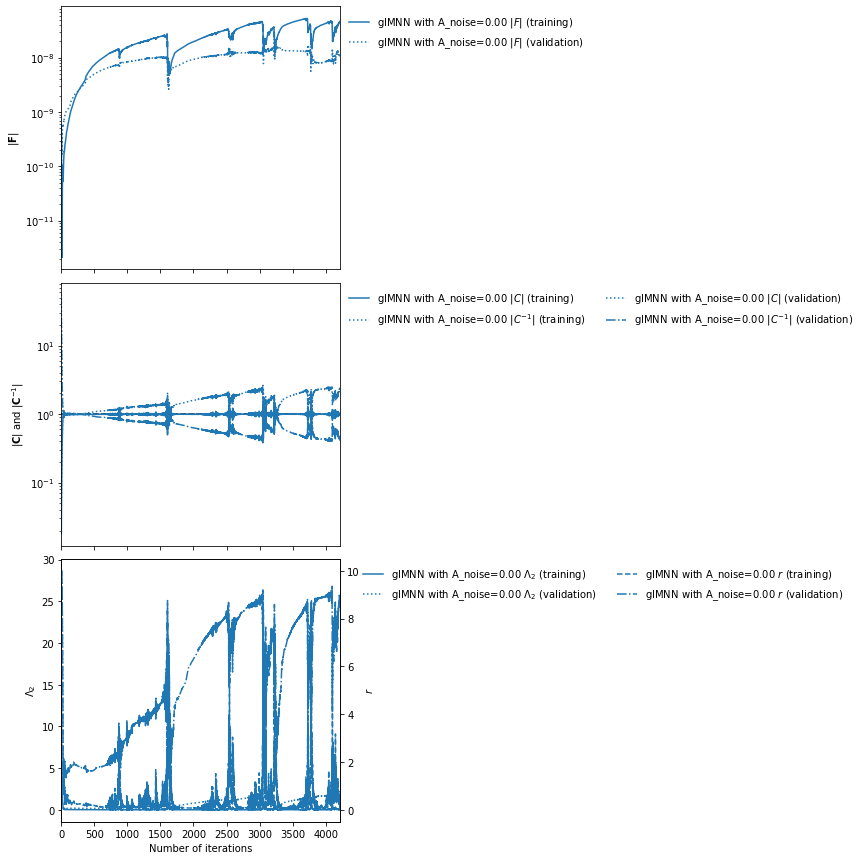

In [59]:
ax = IMNN.plot(label='gIMNN with A_noise=%.2f'%(simulator_args['noise_scale']), 
               expected_detF=None)
ax[0].set_yscale('log')

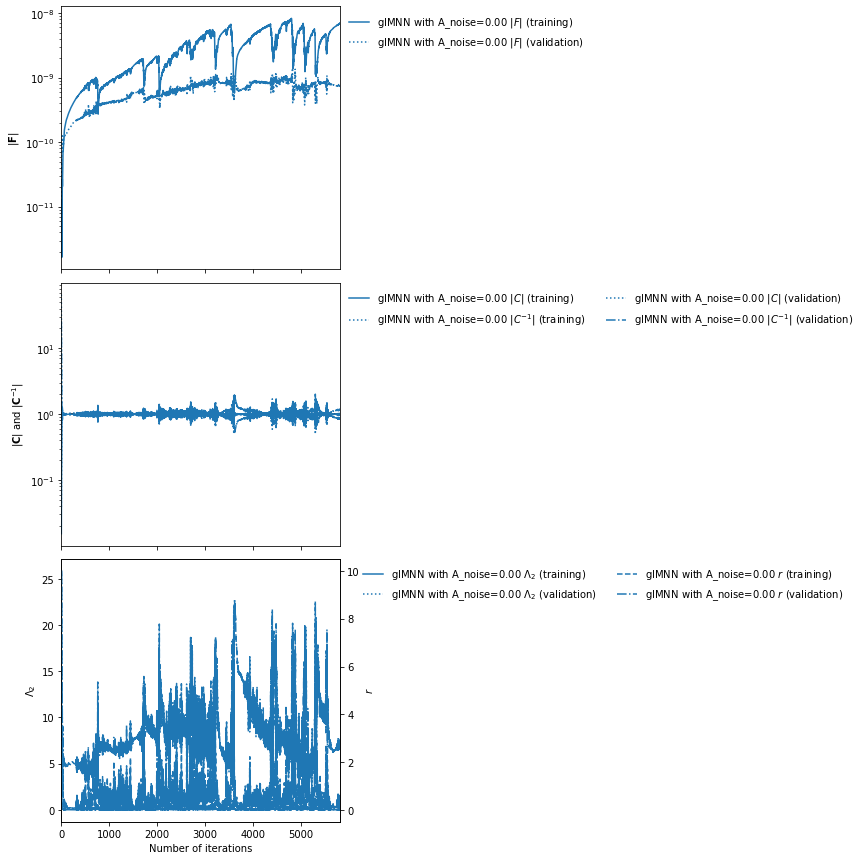

In [97]:
ax = IMNN.plot(label='gIMNN with A_noise=%.2f'%(simulator_args['noise_scale']), 
               expected_detF=None)
ax[0].set_yscale('log')

to load a pre-trained IMNN:

In [ ]:
# uncomment below to load weights
# IMNN_w = load_obj('/content/cosmicGraphs/tutorial/model/IMNN_w_tutorial.pkl')
# start_key = np.load('/content/cosmicGraphs/tutorial/model/model_key.npy')
# IMNN.set_F_statistics(IMNN_w, start_key)
# IMNN.F

DeviceArray([[ 2980.8682,  6240.8496],
             [ 6240.8496, 18846.783 ]], dtype=float32)

# Plot Fisher Contours

In [66]:
IMNN.F

DeviceArray([[9.1483793e-04, 1.2094899e-04],
             [1.2094897e-04, 4.0187533e-05]], dtype=float32)

In [65]:
θ_der

DeviceArray([[-100.,    0.],
             [   0., -100.],
             [ 100.,    0.],
             [   0.,  100.]], dtype=float32)

In [60]:
Fplot = IMNN.F #/ 200**2

In [61]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


# lo = [-300 / 200, -550 / 200]
# hi = [300 / 200, 550 / 200]

lo = [-300, -550]
hi = [300, 550]

prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip(lo, hi)])
prior.low = np.array(lo)
prior.high = np.array(hi)

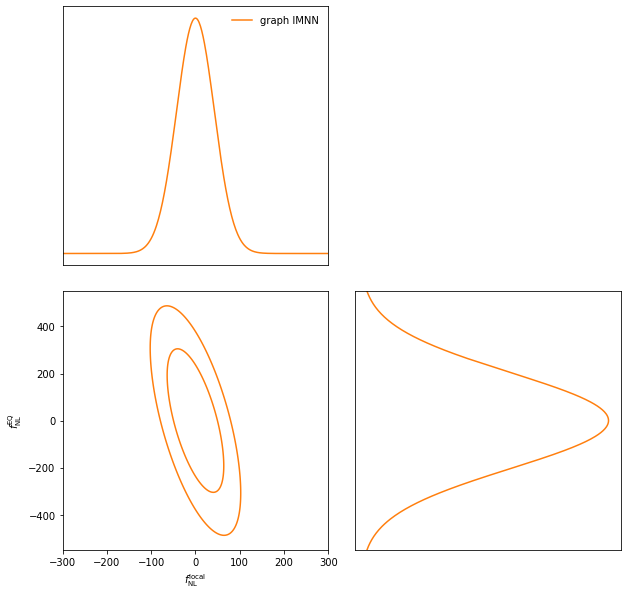

In [62]:
# GA1 = imnn.lfi.GaussianApproximation(
#     parameter_estimates=θ_fid,#IMNN.get_estimate(target_data),
#     invF=np.expand_dims(np.linalg.inv(F_2PCF), 0),
#     prior=prior,
    
#     gridsize=500)
# ax = GA1.marginal_plot(
#     known=θ_fid,
#     label="2-pt function",
#     axis_labels=["$\Omega_m$", "$\sigma_8$"],
#     colours="k", linestyle='-');

# GA = imnn.lfi.GaussianApproximation(
#     parameter_estimates=θ_fid,
#     invF=np.expand_dims(np.linalg.inv(IMNN.F), 0),
#     prior=prior,
#     gridsize=400)


GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=θ_fid,
    invF=np.expand_dims(np.linalg.inv(Fplot), 0),
    prior=prior,
    gridsize=400)
ax = GA.marginal_plot(
    #ax=ax,
    label="graph IMNN",
    axis_labels=[r"$f^{\rm local}_{\rm NL}$", r"$f^{\rm EQ}_{\rm NL}$"],
    colours="C1");

# compute score estimates over some test data at $\vartheta^\pm$

Beyond information quantification, the goal of gIMNNs over cosmic graphs is to condense massive catalogues into a couple of numbers to do density estimation for cosmological parameter constraints, like those done in [Mäkinen et al 2021](https://arxiv.org/abs/2107.07405). To do this effectively, the network *doesn't* need to spit out *exact* predictions for the cosmological parameters like regression networks. Rather, it just needs to be able to distinguish a simulation at one parameter value from another consistently. We're going to compress our test graphs down to parameter estimates using the IMNN method `IMNN.get_estimate(d)`. What this code does is returns the score estimator for the parameters, obtained via the transformation        
$$ \hat{\theta}_{\alpha} = \theta^{\rm fid}_\alpha + \textbf{F}^{-1}_{\alpha \beta} \frac{\partial \mu_i}{\partial \theta_\beta} \textbf{C}^{-1}_{ij} \textbf({x}(\textbf{w}, \textbf{d}) - {\mu})_j $$
where ${x}(\textbf{w}, \textbf{d})$ are the network summaries.


We show this below by computing score summaries over graphs obtained from the *Quijote* suite at $\vartheta^\pm$ *with* cosmic variance -- e.g. non seed-matched simulations.

In [ ]:
_test_derv = load_obj('testgraphs/test_derv_graphs.pkl')

In [ ]:
_test_derv.n_node.shape

(1, 800, 1)

In [ ]:
_test_derv = getgraphs(key, _test_derv, r_connect, num_halos, simulator_args={**simulator_args, "include_pos": True, 
                                                                              'mass_cut': 1.4})

assembling with r_connect =  0.2


In [ ]:
_test_derv.nodes.shape

(800, 200, 7)

In [ ]:
# add noise and re-compute noise
keys = jax.random.split(key, num=800)
# vmap over noise-free fiducial simulation
noisyderv = jax.vmap(noise_simulator)(keys, _test_derv)

In [ ]:
noisyderv.nodes.shape

(800, 200, 4)

In [ ]:
np = jnp
# vmap the network score estimator over the test dataset !
test_derv_estimates = jax.vmap(IMNN.get_estimate)(noisyderv)

Make scatterplot of test dataset summaries (cosmic variance *and* noisy masses)

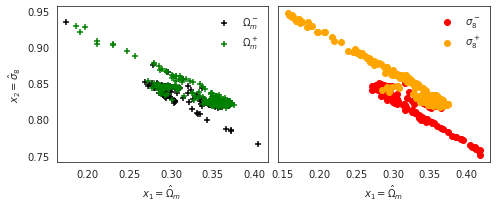

In [ ]:
fig,axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7,3))
_maxnodes = np.max(noisyderv.n_node)

ax = axs[0]
ax.scatter(test_derv_estimates[::4, 0], test_derv_estimates[::4, 1], color='k', 
           label=r'$\Omega_m^-$', marker='+')
ax.scatter(test_derv_estimates[2::4, 0], test_derv_estimates[2::4, 1], color='green', 
           label=r'$\Omega_m^+$', marker='+')
ax.set_xlabel(r'$x_1 = \hat{\Omega}_m$')
ax.set_ylabel(r'$x_2 = \hat{\sigma}_8$')
ax.legend(framealpha=0.)

ax = axs[1]
ax.scatter(test_derv_estimates[1::4, 0], test_derv_estimates[1::4, 1], color='red', 
           label=r'$\sigma_8^-$')

ax.scatter(test_derv_estimates[3::4, 0], test_derv_estimates[3::4, 1], color='orange', 
           label=r'$\sigma_8^+$')
ax.legend(framealpha=0.)
ax.set_xlabel(r'$x_1 = \hat{\Omega}_m$')
plt.tight_layout()

We see that the network is indeed able to distinguish between the different simulations, even with added noise, in line with the degeneracy expected between the two parameters $\Omega_m$ and $\sigma_8$.

# congrats !
You made it through the cosmicGraphs walkthrough. The full analysis done in the paper can be repeated here, on a single GPU ! We hope this helps illustrate our approach to information extraction from large-scale structure